In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [26]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [2]:
import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\logistic_det"

my_path = os.path.abspath(__file)

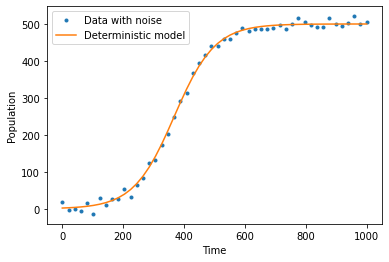

In [10]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.plot(times, values, '.', label="Data with noise")
plt.plot(times, org_values, label="Deterministic model")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
# plt.show()
plt.savefig(my_path + "./log_det_data.pdf")

In [15]:
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Running 3 chains of NUTS

In [27]:
model = toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
nuts_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)
nuts_mcmc.set_max_iterations(1000)

# Set up modest logging
nuts_mcmc.set_log_to_screen(True)
nuts_mcmc.set_log_interval(100)

# Run!
print('Running...')
nuts_chains = nuts_mcmc.run()
print('Done!')


Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     132    0.62962  2       0.333    1       0.571    2        0:00.0
1     135                     0.25     1                         0:00.0
2     138                     0.25     1                         0:00.0
3     147                     0.375    2                         0:00.0


d:\Part B\repos\pints\pints\toy\_logistic_model.py:74: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: overflow encountered in square
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
d:\Part B\repos\pints\pints\toy\_logistic_model.py:83: RuntimeWarning: overflow encountered in square
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp + 1)
d:\Part B\repos\pints\pints\toy\_logistic_model.py:82: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 1] = -k * exp / \
d:\Part B\repos\pints\pints\toy\_logistic_model.py:81: RuntimeWarning: overflow encountered in multiply
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2


100   155121  0.785886 550     0.837    222     0.786    221      0:26.7
200   252483  0.773    322     0.856    46      0.848    46       0:43.1
300   274254  0.786    163     0.89     50      0.845    52       0:47.0
400   280382  0.782    61                                         0:48.2
500   285663  0.78     53                                         0:49.3
600   291095  0.885    54                                         0:50.4
700   296405  0.869    53                                         0:51.4
800   301237  0.853    48                                         0:52.2
900   306383  0.861    51                                         0:53.2
1000  312194  0.876    59                                         0:54.2
Halting: Maximum number of iterations (1000) reached.
Done!


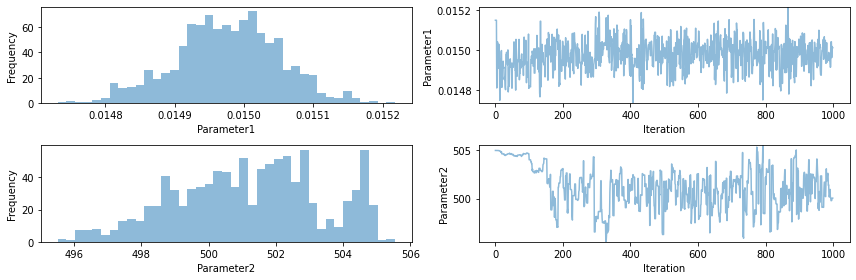

R-hat:
[1.03504931 1.32561804]


In [28]:
nuts_chains = nuts_chains

pints.plot.trace([nuts_chains[0, :]])
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat(nuts_chains))

# Creating a stochastic process

In [6]:
class ErrorLogisticModel(pints.ForwardModelS1, pints.toy.ToyModel):
    def __init__(self, initial_population=2):
        super(ErrorLogisticModel, self).__init__()
        self._model = toy.LogisticModel(initial_population)
    
    def n_parameters(self):
        return 2
    
    def simulate(self, parameters, times):
        org_values = self._model.simulate(parameters, times)
        return org_values + np.random.normal(0, noise, org_values.shape)

    def suggested_parameters(self):
        return np.array([0.1, 50])
    
    def suggested_times(self):
        return np.linspace(0, 100, 100)

In [7]:
s_model = ErrorLogisticModel()
problem = pints.SingleOutputProblem(s_model, times, values)
error_measure = pints.RootMeanSquaredError(problem)

# Running ABC Rejection

In [19]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior)

# set threshold
abc.sampler().set_threshold(13)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     503    0.00198807157    0:00.1
2     2605   0.000767754319   0:00.3
3     4479   0.000669792364   0:00.4
20    21345  0.000936987585   0:01.8
40    41056  0.000974279034   0:03.4
60    59425  0.00100967606    0:04.9
80    73611  0.00108679409    0:06.0
100   93273  0.00107212162    0:07.5
120   107936  0.00111176994    0:08.7
140   120784  0.00115909392    0:09.7
160   132400  0.00120845921    0:10.6
180   145812  0.0012344663     0:11.7
200   159869  0.00125102428    0:12.8
220   174504  0.00126071609    0:13.9
240   193478  0.00124045111    0:15.3
260   205163  0.00126728504    0:16.3
280   219946  0.00127303975    0:17.5
300   234143  0.00128126828    0:18.6
320   248491  0.001287773      0:19.7
340   266446  0.00127605594    0:21.1
360   279859  0.00128636206    0:22.2
380   311428  0.00122018573    0:24.6
400   323983  0.00123463268    0:25.6
420   342257  0.00122714802    0:27.0


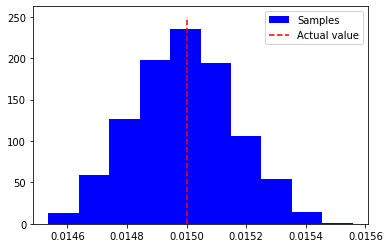

In [20]:
samples_flat = np.array([item for sublist in samples for item in sublist])

# print(samples_flat[:])
plt.hist(samples_flat[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

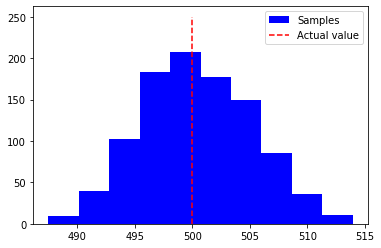

In [21]:
plt.hist(samples_flat[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

In [25]:
samples_abc_rej = samples_flat

[]

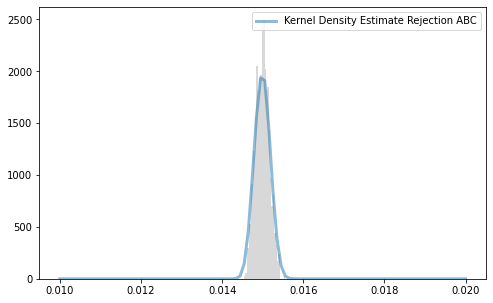

In [33]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

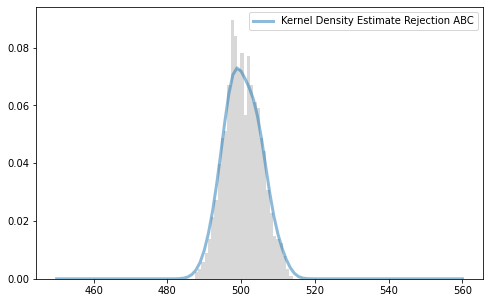

In [35]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# ABC PMC

In [36]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([20, 15, 13]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(1000)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=15
Trying t=2, threshold=13
Iter. Eval. Acceptance rate Time m:s
1     63018  1.5868482e-05    1:53.1
2     63168  3.16616008e-05   1:53.5
3     63717  4.7083196e-05    1:54.7
20    67523  0.00029619537    2:03.7
40    71157  0.000562137246   2:13.0
60    74079  0.000809946139   2:20.6
80    77744  0.00102901832    2:29.4
100   81014  0.00123435456    2:36.9
120   84377  0.00142218851    2:45.0
140   87324  0.00160322477    2:51.8
160   90300  0.00177187154    2:58.6
180   92957  0.00193637919    3:04.8
200   96082  0.00208155534    3:12.0
220   99671  0.00220726189    3:20.2
240   103326  0.00232274549    3:28.9
260   106468  0.00244204831    3:39.3
280   110257  0.0025395213     3:48.6
300   114771  0.00261390072    3:59.7
320   117924  0.00271361216    4:10.0
340   122697  0.0027710539     4:28.9
360   125882  0.0028598211     4:37.0
380   128640  0.0029539801     4:44.2
400   131567  0.00304027606    4:51.6
420   13461

In [37]:
samples_pmc_true = samples

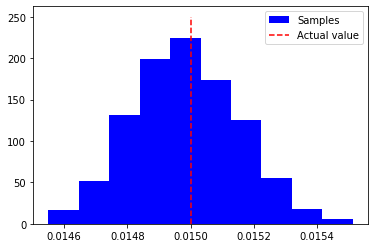

In [38]:
plt.hist(samples_pmc_true[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

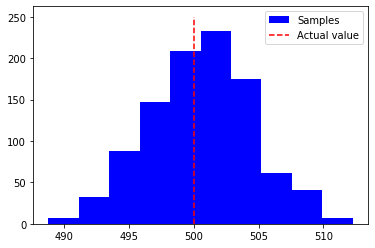

In [39]:
plt.hist(samples_pmc_true[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

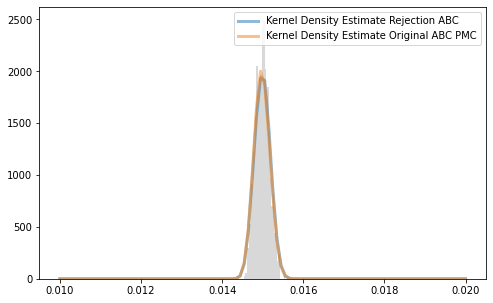

In [41]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

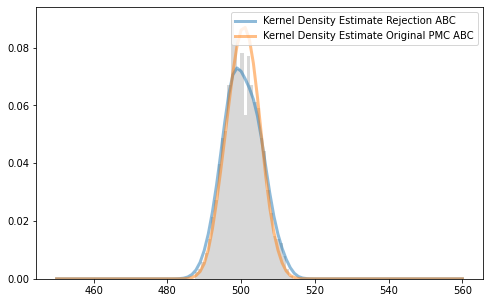

In [42]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# PMC Modified

In [40]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
# set initial threshold
abc.sampler().set_threshold_schedule(np.array([20, 15, 13]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

samples = abc.run()
print("Done")

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=15
Trying t=2, threshold=13
Iter. Eval. Acceptance rate Time m:s
1     12333  8.10832725e-05   0:19.7
2     12765  0.000156678418   0:20.5
3     12930  0.000232018561   0:20.7
20    15424  0.0012966805     0:25.1
40    19529  0.00204823596    0:32.1
60    22956  0.00261369577    0:37.8
80    25401  0.0031494823     0:41.8
100   28826  0.0034690904     0:47.6
120   31417  0.00381958812    0:51.9
140   33725  0.00415122313    0:56.2
160   38165  0.00419232281    1:03.7
180   40953  0.0043952824     1:10.3
200   43844  0.00456162759    1:15.2
220   47754  0.00460694392    1:24.2
240   51361  0.00467280621    1:31.3
260   56960  0.00456460674    1:42.4
280   62592  0.00447341513    1:52.4
300   66153  0.00453494173    1:58.2
320   69410  0.0046102867     2:03.8
340   73629  0.00461774573    2:11.0
360   77706  0.00463284688    2:21.0
380   82534  0.00460416313    2:29.5
400   86362  0.00463166671    2:35.6
420   90589  0.00463

In [43]:
samples_pmc_fake = samples

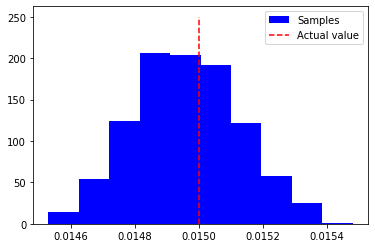

In [44]:
plt.hist(samples_pmc_fake[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

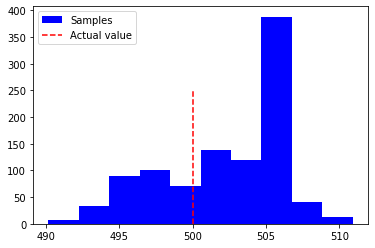

In [45]:
plt.hist(samples_pmc_fake[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

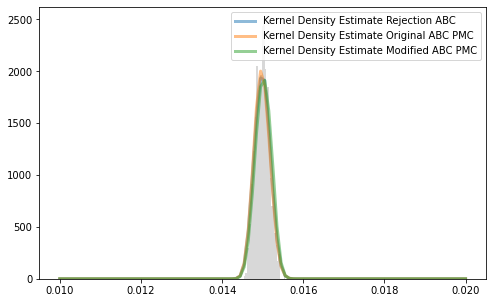

In [63]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original ABC PMC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified ABC PMC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

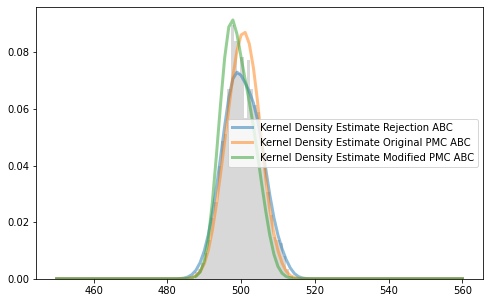

In [64]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# ABC Adaptive PMC

In [71]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

# set threshold
abc.sampler().set_N_l(900)

# set p_acc_min
abc.sampler().set_p_acc_min(0.05)

# set target number of samples
abc.set_n_samples(1000)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[1.54588125e-02 5.08047749e+02]
resulting var=[[ 1.34415153e-05 -1.23955828e-02]
 [-1.23955828e-02  2.05697537e+03]]
epsilon=84.94175194367752
w_mean=[1.57286520e-02 5.02866089e+02]
resulting var=[[ 1.20371504e-05 -1.97532419e-02]
 [-1.97532419e-02  1.99395559e+03]]
epsilon=74.91120256490521
w_mean=[1.54718852e-02 5.03554712e+02]
resulting var=[[ 1.03586466e-05 -3.84090764e-02]
 [-3.84090764e-02  1.98895904e+03]]
epsilon=68.81644691904575
w_mean=[1.56012178e-02 5.03308792e+02]
resulting var=[[ 8.59356903e-06 -3.29454328e-02]
 [-3.29454328e-02  1.82131229e+03]]
epsilon=63.90070883253226
w_mean=[1.54310825e-02 5.03163378e+02]
resulting var=[[ 7.32262955e-06 -3.30245370e-02]
 [-3.30245370e-02  1.79811117e+03]]
epsilon=59.970892565648136
w_mean=[1.53364281e-02 5.03756163e+02]
resulting var=[[ 6.40464268e-06 -3.30158683e-02]
 [-3.30158683e-02  1.80059712e+03]]
epsilon=55.750338862839165
w_mean=[1.52700053e-02 5.03095271e+0

In [72]:
samples_adaptive = samples

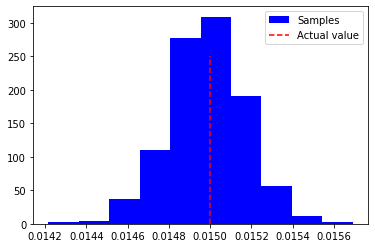

In [73]:
plt.hist(samples_adaptive[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

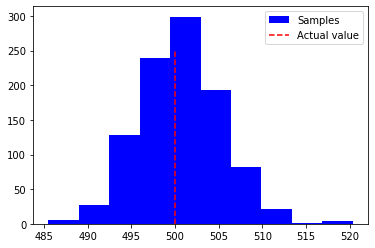

In [74]:
plt.hist(samples_adaptive[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

[]

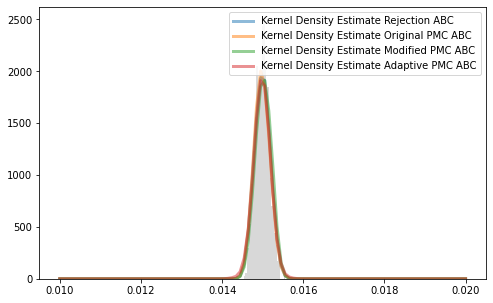

In [75]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))


ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

[]

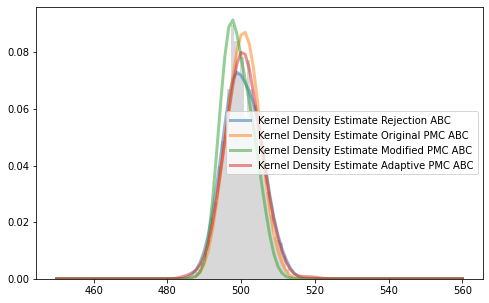

In [76]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc_rej)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=2),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
ax.plot()

# Hamiltonian ABC

In [11]:
from scipy.stats import multivariate_normal

class ActuallySyntheticLikelihood:
    def __init__(self, y, eps):
        y = np.array(y)
        if len(y.shape) == 1:
            self._y = np.array([y])
        else:
            self._y = np.array(y)
        self._eps = eps
        if isinstance(self._eps, (list, tuple, np.ndarray)):
            self._eps = np.diag(np.square(self._eps))

    def pdf(self, vals):   
        # estimate mean
        t_mean = np.zeros((len(self._y), len(self._y[0])))
        
        for j in range(len(self._y)):
            for i in range(len(vals)):
                t_mean[j] += vals[i][j]
            t_mean[j] /= (len(vals))
        
        t_cov = np.zeros( (len(self._y), len(self._y[0]), len(self._y[0])) )
        
        for i in range(len(self._y)):
            for j in range(len(vals)):
                one_t = np.array([vals[j][i] - t_mean[i]])
                t_cov[i] += one_t * np.transpose(one_t)
            
            t_cov[i] /= (len(vals) - 1)
            t_cov[i] += self._eps
            
        rez = 0
        
        for i in range(len(self._y)):
            rez += (multivariate_normal.pdf(self._y[i], mean=t_mean[i], cov=t_cov[i]))


        rez = np.log(rez)
        return rez

In [13]:
class HABCsgld:
    def __init__(self, T, theta0, m, eps, s_eps, log_prior, sim_f, c, y):
        self._T = T
        self._theta0 = theta0
        self._dim = len(theta0)
        self._m = m
        self._eps = eps
        self._c = c
        self._cnt = 0
        self._mean = np.zeros(self._dim)
        
        # Functions
        self._log_prior = log_prior
        self._grad_prior = self.grad_pr 
        self._sim_f = sim_f
        self._cnt_samples = 0
        
        # Build synthetic likelihood
        self._synt_l = ActuallySyntheticLikelihood(y, s_eps)
        
        self._grads = []
    
    def grad_pr(self, theta):
        x, dx = self._log_prior.evaluateS1(theta)
        return dx
    
    def spsa(self, theta, d_theta, S, R):
        self._grads = None
        if (len(theta.shape) > 1):
            dim = len(theta[0])
        else:
            dim = len(theta)
        g = np.zeros(dim)
        
        for r in range(R):
            # Generate bernoulli distribution vector
            delta = np.zeros(dim)
            for i in range(dim):
                delta[i] = (2 * np.random.binomial(n=1, p=0.5) - 1)
            
            
            set_plus = None
            set_minus = None
            
            aux = 0
            
            for s in range(S):
                x_plus = self._sim_f(theta + d_theta * delta)
                x_minus = self._sim_f(theta - d_theta * delta)
                self._cnt_samples += 2
                
                if len(x_plus.shape) == 1:
                    x_plus = [[x] for x in x_plus]
                if len(x_minus.shape) == 1:
                    x_minus = [[x] for x in x_minus]
                    
                if set_plus is None:
                    set_plus = [x_plus]
                    set_minus = [x_minus]
                else:
                    set_plus.append(x_plus)
                    set_minus.append(x_minus)
            term = (self._synt_l.pdf(set_plus) - self._synt_l.pdf(set_minus)) * delta
            g += term

        g = ( 1 / (2 * d_theta * R) ) * g
        
        grad_val = self.grad_pr(theta)
        # if len(grad_val.shape) > 1:
            # grad_val = grad_val[0]
        g += np.exp(grad_val)
        
        return -g
        
    def run(self):
        # Initialize stuff
        self._results = [self._theta0]
        
        for t in range(1, self._T):
            done = False
            
            while not done:
                # Resample momentum
                
                curr_theta = self._results[t-1]
                curr_momentum = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim))
                
                i = 0
                problem = False
                
                while not problem and i <= self._m:
                    spsa_term = self.spsa(curr_theta, 0.0001, S=2, R=2)
                    next_theta = curr_theta + self._eps * np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim)) - \
                                 (self._eps ** 2) / 2 * spsa_term
                    # print("next theta computed="+str(next_theta))
                    if self._log_prior(next_theta + 0.0001 * np.ones(self._dim)) == np.NINF \
                        or self._log_prior(next_theta - 0.0001 * np.ones(self._dim)) == np.NINF:
                        print("FAILED")
                        problem = True
                    else:
                        
    #                     print("spsa_term=" + str(spsa_term * self._eps))
    #                     print("second term=" + str(self._eps * self._C * curr_momentum))
    #                     print("third term=" + str(np.random.multivariate_normal(np.zeros(self._dim), 2 * self._eps * (self._C - self._B))))
    #                     print("next_theta="+str(next_theta))
    #                     print("next_momentum="+str(next_momentum))
                        curr_theta = next_theta
                        if self._log_prior(curr_theta) == np.NINF:
                            problem = True
                        i = i + 1
                if not problem:
                    done = True
                    self._results.append(curr_theta)
            print("t= " + str(t) + ", " + "curr_theta =" + str(curr_theta))
        
        print("count samples = "+str(self._cnt_samples))
        return self._results

In [16]:
np.random.seed(1)

y = np.array([[x] for x in values])

theta0 = np.array([0.012, 480])

def grad_prior(theta):
    x, dx = log_prior.evaluateS1(theta)
    return dx

# Simulating function
def sim_f(theta):
#     print("trying " + str(theta))
    if len(theta.shape) == 2:
        theta = theta[0]
#     print("in the end we have " + str(theta))
    return s_model.simulate(theta, times)

# seed 1,  0.0005, 0.05
abc = HABCsgld(1000, theta0, 10, np.array([0.0005, 0.05]), 0.1, log_prior, sim_f, 0.001, y)

print("abc started")        

results = abc.run()

print("abc finished")
print(results)

abc started
FAILED
t= 1, curr_theta =[1.14402344e-02 4.84506673e+02]
t= 2, curr_theta =[1.13688805e-02 4.85595213e+02]
t= 3, curr_theta =[1.28912110e-02 4.93551892e+02]
t= 4, curr_theta =[1.46551525e-02 4.92217725e+02]
t= 5, curr_theta =[1.58586237e-02 4.94065774e+02]
t= 6, curr_theta =[1.43226508e-02 4.92315309e+02]
t= 7, curr_theta =[1.60024207e-02 4.99398768e+02]
t= 8, curr_theta =[1.56560143e-02 4.94683339e+02]
t= 9, curr_theta =[1.49876189e-02 4.94764310e+02]
t= 10, curr_theta =[1.43950517e-02 4.93769280e+02]
t= 11, curr_theta =[1.29577501e-02 4.88741804e+02]
t= 12, curr_theta =[1.47046272e-02 5.01108291e+02]
t= 13, curr_theta =[1.68997203e-02 4.96543076e+02]
t= 14, curr_theta =[1.52510244e-02 5.02808373e+02]
t= 15, curr_theta =[1.46454162e-02 5.03913195e+02]
t= 16, curr_theta =[1.35757798e-02 5.01733379e+02]
FAILED
t= 17, curr_theta =[1.50946494e-02 5.07799719e+02]
t= 18, curr_theta =[1.59806555e-02 5.17376466e+02]
t= 19, curr_theta =[1.57274584e-02 5.19745022e+02]
t= 20, curr_th

In [18]:
samples_hamiltonian = np.array(results)

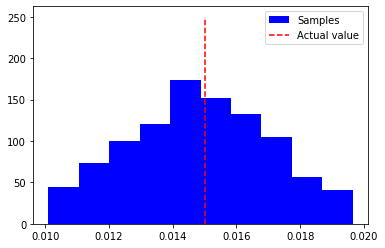

In [19]:
plt.hist(samples_hamiltonian[:,0], color="blue", label="Samples")
plt.vlines(x=0.015, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

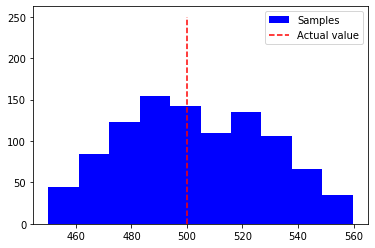

In [20]:
plt.hist(samples_hamiltonian[:,1], color="blue", label="Samples")
plt.vlines(x=500, linestyles='dashed', ymin=0, ymax=250, label="Actual value", color="red")
plt.legend()
plt.show()

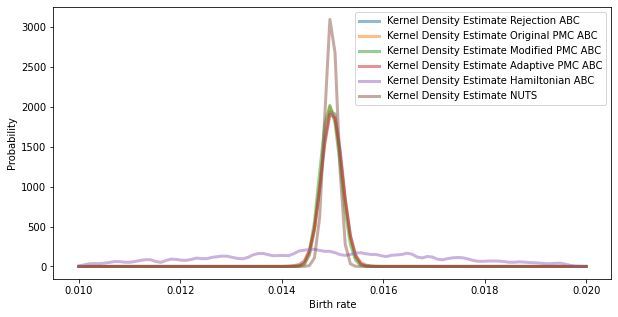

In [46]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(0.01, 0.02, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))


ax.plot(x_grid, kde_sklearn(np.array(samples_abc)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(nuts_chains[0, :])[:, 0], x_grid, bandwidth=0.0001),
            label='Kernel Density Estimate NUTS', linewidth=3, alpha=0.5)
# ax.hist(samples_abc_rej[:, 0], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
# ax.plot()
plt.ylabel("Probability")
plt.xlabel("Birth rate")
plt.savefig(my_path + './logistic_det_kde_x.pdf')

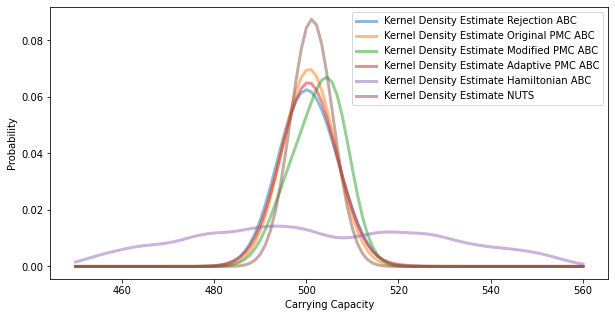

In [49]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

x_grid = np.linspace(450, 560, 100)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10, 5))

ax.plot(x_grid, kde_sklearn(np.array(samples_abc)[:, 1], x_grid, bandwidth=4),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_true)[:, 1], x_grid, bandwidth=4),
            label='Kernel Density Estimate Original PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_pmc_fake)[:, 1], x_grid, bandwidth=4),
            label='Kernel Density Estimate Modified PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_adaptive)[:, 1], x_grid, bandwidth=4),
            label='Kernel Density Estimate Adaptive PMC ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(samples_hamiltonian)[:, 1], x_grid, bandwidth=4),
            label='Kernel Density Estimate Hamiltonian ABC', linewidth=3, alpha=0.5)
ax.plot(x_grid, kde_sklearn(np.array(nuts_chains[0, :])[:, 1], x_grid, bandwidth=4),
            label='Kernel Density Estimate NUTS', linewidth=3, alpha=0.5)
# ax.hist(samples_abc_rej[:, 1], 30, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend()
plt.ylabel("Probability")
plt.xlabel("Carrying Capacity")
# ax.plot()
plt.savefig(my_path + './logistic_det_kde_y.pdf')

# Compute KL

In [50]:
from scipy import integrate

def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

def kl_func_x(y, kde_skl):
    part = kde_sklearn(np.array(nuts_chains[0, :])[:, 0], np.array([y]), bandwidth=0.0001)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if part == 0:
        return 0
    elif s_part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_x(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.01, 0.02)

def kl_func_y(y, kde_skl):
    part = kde_sklearn(np.array(nuts_chains[0, :])[:, 1], np.array([y]), bandwidth=2)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 450, 560)

saved_abc_rej = kl_div_x(np.array(samples_abc)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_abc)[:, 1], 4)[0]
saved_fake_pmc = kl_div_x(np.array(samples_pmc_fake)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_pmc_fake)[:, 1], 4)[0]
saved_orig_pmc = kl_div_x(np.array(samples_pmc_true)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_pmc_true)[:, 1], 4)[0]
saved_adaptive = kl_div_x(np.array(samples_adaptive)[:, 0], 0.0001)[0] + kl_div_y(np.array(samples_adaptive)[:, 1], 4)[0]

s_x = kl_div_x(np.array(samples_hamiltonian)[:, 0], 0.0001)[0] 
s_y = kl_div_y(np.array(samples_hamiltonian)[:, 1], 2)[0]
saved_hamiltonian = s_x + s_y

print("ABC REJ KL = " + str(saved_abc_rej))
print("MOD PMC KL = " + str(saved_fake_pmc))
print("ORIG PMC KL = " + str(saved_orig_pmc))
print("ADAPTIVE KL = " + str(saved_adaptive))
print("HAMILTONIAN KL = " + str(saved_hamiltonian))

ABC REJ KL = 0.5501143923272476
MOD PMC KL = 0.5649053112839463
ORIG PMC KL = 0.45457182611544245
ADAPTIVE KL = 0.5421090458278554
HAMILTONIAN KL = 4.271473129779779


# Data

In [67]:
print(samples_abc_rej.tolist())

[[0.014911169714646384, 495.6026448548122], [0.014867011131772415, 508.85743240340895], [0.014896424733339662, 506.52407835279934], [0.015025145820575419, 496.68211839833276], [0.015075873333388078, 507.05592137259566], [0.015168300929265452, 493.18797123423366], [0.01491013751263277, 503.18318162269077], [0.014718343669454851, 505.6377503397744], [0.014993287702000025, 501.9639566990596], [0.014956414784113888, 503.119529261914], [0.015193678622154441, 497.50066172896317], [0.014756085210463437, 503.7966293496393], [0.015037470348970097, 499.75428323683184], [0.01518293281558746, 500.75767115778865], [0.014671509801899612, 505.2353364951725], [0.015304381094636766, 503.1710446133351], [0.01518752185269415, 498.4099162064], [0.015382035751139818, 495.10960482668673], [0.015089916185151722, 492.4294720044254], [0.015098471022718472, 499.81593372363756], [0.0151338997653141, 503.9955373648744], [0.015170221485302098, 497.50241690019106], [0.014942390761158731, 506.5868147272519], [0.0149

In [21]:
samples_abc = [[0.014911169714646384, 495.6026448548122], [0.014867011131772415, 508.85743240340895], [0.014896424733339662, 506.52407835279934], [0.015025145820575419, 496.68211839833276], [0.015075873333388078, 507.05592137259566], [0.015168300929265452, 493.18797123423366], [0.01491013751263277, 503.18318162269077], [0.014718343669454851, 505.6377503397744], [0.014993287702000025, 501.9639566990596], [0.014956414784113888, 503.119529261914], [0.015193678622154441, 497.50066172896317], [0.014756085210463437, 503.7966293496393], [0.015037470348970097, 499.75428323683184], [0.01518293281558746, 500.75767115778865], [0.014671509801899612, 505.2353364951725], [0.015304381094636766, 503.1710446133351], [0.01518752185269415, 498.4099162064], [0.015382035751139818, 495.10960482668673], [0.015089916185151722, 492.4294720044254], [0.015098471022718472, 499.81593372363756], [0.0151338997653141, 503.9955373648744], [0.015170221485302098, 497.50241690019106], [0.014942390761158731, 506.5868147272519], [0.014929744071308353, 503.1238569618133], [0.014752311763805932, 511.1277597298223], [0.014890226964947496, 495.5934663052995], [0.014795765986973224, 507.1167052915098], [0.014915712962487736, 510.64781030240226], [0.015164273257048966, 492.5760449345388], [0.014881493290559388, 501.476618076309], [0.015144852010665335, 492.09472265673514], [0.01514457459061078, 499.0197404791947], [0.014990575885795988, 500.1504814772796], [0.014752803854580873, 506.02556024876327], [0.014920334526103802, 500.09498810576304], [0.014872569168802509, 500.3866824743269], [0.015106185745907993, 498.99850013095795], [0.01520633789177339, 499.0308945743124], [0.015258794813695308, 492.7719476114089], [0.015183669349845146, 489.75053312391924], [0.01526852816314213, 497.7388075557032], [0.014861451345161078, 503.32514563936553], [0.01507308103970699, 499.0728511098337], [0.015153670348751952, 493.6223977513212], [0.015077914985358513, 496.53794069791104], [0.015077038697636894, 494.6440482311583], [0.014777713616635033, 498.4847940878335], [0.014963391931111762, 502.8594080456579], [0.01489833973147717, 507.0218602935103], [0.014672709484920683, 498.7887452393955], [0.014979960704406757, 502.8708559005003], [0.014830104829574387, 501.6884297356778], [0.015018595285566498, 507.7572841584936], [0.014818287618354022, 497.3752301553868], [0.01479171040151252, 500.5818071483051], [0.015030416254700052, 504.68883444403036], [0.014955343494274116, 506.0918990394828], [0.014948726182573549, 503.0986216178766], [0.014838376355372546, 506.59307438041304], [0.015019699111258063, 502.4369556822012], [0.014754395352014242, 500.17265097699544], [0.015090947207355907, 500.9391398955181], [0.01498557933941749, 497.7430575140717], [0.015079829835988311, 502.2397087197661], [0.01473121930230473, 500.2796844434762], [0.014946756257868732, 502.11576867624854], [0.015040705179431648, 496.5777258661849], [0.014949494607567053, 489.99439885473], [0.014826162860988338, 503.36963709313034], [0.01497616970664714, 496.4898256510601], [0.015097578156911325, 496.81809650344564], [0.01491984413658268, 502.541978068842], [0.015000974419598127, 493.8616084695869], [0.015288356265992833, 498.4138745678618], [0.015392410398698863, 498.54273551275844], [0.015007346474843137, 502.7551679329295], [0.015081826629735772, 495.58361224228753], [0.015059752788136493, 495.2881487082452], [0.014898404060786366, 504.34729220246226], [0.014845121184411423, 508.54817099371064], [0.015025713680659462, 499.5595426716267], [0.01527581673276885, 503.2813885778229], [0.014910139646863484, 496.5110644131529], [0.014841779964667047, 505.25570629116066], [0.015020939475510187, 498.2775751803781], [0.015046205330902505, 505.42600590504725], [0.015284610426590343, 502.3503556013541], [0.015107543931807112, 500.3573118692244], [0.015060008654082038, 496.7360911043984], [0.014854669855887275, 509.8318517211954], [0.01521151974977257, 505.0223465114346], [0.01467994583917687, 511.53898279686695], [0.01535207487877157, 499.2685689335979], [0.014652173518352855, 507.9872469502499], [0.014873207798920728, 500.01909479963035], [0.015102567681935661, 503.4515195734234], [0.014798737160398173, 505.4096902915992], [0.015078919094864947, 498.05262822532524], [0.014844946883529206, 496.4387330566378], [0.01509998346452487, 501.8567832255364], [0.015000989465626533, 501.86320474675733], [0.014820453676821645, 502.15470225406386], [0.014931988063400497, 500.28473935521566], [0.015091255221159252, 495.34253861015594], [0.014813269660760544, 491.6286237500184], [0.015043197016515113, 500.9718213902675], [0.014629258420312746, 506.0671239026925], [0.014856033867591286, 506.25619015029423], [0.014988751882157595, 497.6415451584703], [0.01490141535608075, 504.53638950486516], [0.01537337024420133, 501.4236487067324], [0.01497712518006193, 497.38600573642674], [0.014929269803775107, 504.5831544781048], [0.01488411255612508, 499.0127480900919], [0.014718360862070417, 504.48313434661725], [0.014984962118315459, 497.45316768566187], [0.01505287811681522, 497.6893180662546], [0.015009577921104907, 496.3782983455321], [0.015026570796621737, 493.94161600678086], [0.015309461699755557, 496.6281766710256], [0.014831022582767684, 504.125492487178], [0.014982779344573031, 511.55546577871826], [0.014997740116952695, 493.17893187481695], [0.015024200939882722, 495.8560949821304], [0.01500412588659241, 501.90624278972496], [0.014947588927524187, 500.7578013213806], [0.01474994540919983, 504.5459119583442], [0.015321735656108958, 491.48493771575295], [0.01524044152837772, 502.4271379807616], [0.014610012501694426, 496.9542268392298], [0.015078407104079096, 492.83414073979225], [0.014920873989445384, 498.7962791656238], [0.014917868547339303, 498.29754834295494], [0.015109965264979671, 504.6479899780471], [0.014993171990567924, 491.09434480895777], [0.015053811663289392, 502.03529008954246], [0.015027218247492858, 500.117420583573], [0.01495239534617128, 505.0277651744626], [0.015283839015499363, 497.43600500645005], [0.015023398943287546, 504.1473885108952], [0.015108405782501885, 498.22865675949686], [0.015046050277458981, 502.77178787999486], [0.015180718786318582, 504.77193485075543], [0.014940305072131862, 504.13662021436767], [0.014855485801092989, 501.2800228615991], [0.014959389244769205, 499.95223733185617], [0.015041830811048915, 506.5788144718883], [0.014940283129713055, 503.37716188940317], [0.015162210933563108, 502.4280488126943], [0.01507023506437755, 495.7467880675308], [0.014863976852141384, 507.60744250746075], [0.015068868149097499, 502.1654860088679], [0.014924500907298716, 504.6563593701384], [0.014840236963348252, 496.17763987869085], [0.015076325958537907, 495.2029159813344], [0.015085665890801025, 497.1345849329646], [0.015015709774061222, 500.2941156493538], [0.014640651101697485, 498.2819712190284], [0.014980146565858516, 495.34321203483324], [0.014985107272765624, 498.66489051437225], [0.015141235379653189, 505.0236776956474], [0.014978519855393727, 496.69780222383656], [0.015128896719458709, 492.019096352164], [0.015032532305409865, 503.3736798214295], [0.015119540726633789, 494.24091852395117], [0.015254945401571574, 503.9227564570552], [0.015102379857366257, 494.25000500278503], [0.014868900410374693, 509.4068493632957], [0.014961482534905882, 496.052567988503], [0.015056935887012159, 495.0136006513803], [0.014868016896283621, 501.2189243295909], [0.014931368997344445, 497.4631384921704], [0.014985079544452027, 499.8873941710585], [0.014826811227651504, 502.4268289567345], [0.014716907217657303, 499.42761666059687], [0.014921819029421086, 505.36706149584893], [0.014820660715139874, 509.6887987814248], [0.014832401154114104, 504.22071661076666], [0.014870633197654234, 498.85540935940776], [0.015074032236448338, 499.84450413306274], [0.014789481585125823, 504.662163995332], [0.014988707050606195, 500.43886707175534], [0.015064438574068275, 496.6965154988864], [0.015133841482392291, 501.34882316405304], [0.01504953776890057, 506.8908152758788], [0.015035264408579514, 499.0702118760971], [0.014902984732675068, 501.24875551660335], [0.014877287855460424, 496.4849487349098], [0.014819734212918805, 499.39405594413387], [0.01479973608603412, 498.44365235232533], [0.015022986733473402, 504.9972380004325], [0.015019027952017833, 502.85438755307916], [0.014855215577907728, 502.848180429095], [0.014929237886597443, 503.9921786052137], [0.015075241847393228, 505.3517464123996], [0.014958591265050409, 501.5967289558175], [0.014609554284740924, 503.0202775612606], [0.015020914524618286, 502.5825705300875], [0.015104114728588742, 499.95794488659584], [0.014834488970975224, 502.0100844405492], [0.015058052042211393, 497.0024822894553], [0.015162586576633694, 491.0921910854302], [0.015135668124587597, 498.47154780763583], [0.014792546944788938, 499.757252369925], [0.01494440240892053, 504.44548936560636], [0.014902195721774598, 499.51577497298075], [0.01510768533132448, 504.5507773366621], [0.015144689142307873, 496.9957912559366], [0.014983062195482687, 496.609605256352], [0.014877874255043038, 510.72169974502344], [0.015270180633933815, 506.7809539922982], [0.015166472435545263, 498.8186235545481], [0.014735151739046184, 507.30692743234414], [0.01476398980799399, 502.6135152410539], [0.014614874705781617, 513.9460156265759], [0.014944728337696809, 499.37741543298404], [0.014868304890182264, 500.17598482461494], [0.014902239025685687, 499.54756193542016], [0.014855824701863096, 511.7259488465774], [0.01493338101329886, 498.88863601681953], [0.014830543174283747, 498.33999461094453], [0.01502263634980833, 497.07423428099867], [0.014910652265671955, 505.6505227554266], [0.015298080147707034, 490.2350594028679], [0.015044732209112888, 500.25183615857736], [0.014944080839388148, 511.7159229918669], [0.014867523483907102, 492.14205853006126], [0.015025512331951412, 501.22779134056503], [0.014620535763451546, 513.0099217030239], [0.014911246641083922, 501.1542985865702], [0.015289920045986234, 494.50057602042784], [0.014854827151749832, 498.48337156163603], [0.014901472633650967, 500.7932661751934], [0.015136043794532907, 499.4303359474097], [0.01517941308738443, 504.4252768371783], [0.015101446471606612, 492.70689733721514], [0.015067850980589166, 494.602789144751], [0.015021105166321408, 498.31320095685834], [0.014999714253467314, 500.4090022381148], [0.015295232185271318, 495.87096415260766], [0.014894675847430379, 503.8625523091665], [0.014971561827098235, 508.7344673310014], [0.015192930367388379, 501.6985637825564], [0.015175991000595817, 498.916576892535], [0.01528375988285182, 494.2597170611002], [0.01507121079101022, 497.7850795966567], [0.01481279972741424, 500.7501409313514], [0.014936770312282062, 503.8418502341592], [0.015313141326886003, 493.9988738521172], [0.014958364590722802, 497.9674544710239], [0.014976078243668523, 504.07652828429076], [0.015132964969014489, 503.20854939513083], [0.01492834116886279, 502.45885213180065], [0.014956131411333992, 497.5683015720485], [0.014840391286605335, 501.54081859850413], [0.015181962290936605, 500.2437652732058], [0.015156505054924555, 502.8912271421052], [0.01479238420297491, 499.93600290010727], [0.014891130400836096, 508.6655140758206], [0.015139215797613608, 494.328013354812], [0.014964204540869393, 502.82899727915475], [0.014759246554283416, 504.4013446565941], [0.014855996425345106, 500.74176287184275], [0.015199633199556615, 501.3747010289449], [0.014830107640503364, 501.75541386076446], [0.014853307534735353, 495.5558364600275], [0.015337579490873665, 490.88655822852144], [0.015035138729821172, 504.2246996694712], [0.014852179861741963, 508.68623160348864], [0.015001131041139943, 497.2868067735426], [0.01497605308818439, 502.0253689890636], [0.014894315445261225, 504.2259303118485], [0.01527107696261372, 495.42357988513294], [0.015043249011983922, 507.88471085198813], [0.015089295461438633, 497.74519243894326], [0.01506985729776841, 500.0313656541281], [0.015169339910651895, 494.3319276123496], [0.014625086544895315, 498.86211980158185], [0.014937964861017592, 497.99287555252124], [0.014861951464576629, 510.8980318191245], [0.01515612361786724, 497.5355219065508], [0.015137367154558407, 497.0049565005846], [0.015030199382241607, 504.2332896852693], [0.014706919631589061, 500.2266446163158], [0.01527585295558331, 494.8125500950296], [0.014918891737484114, 503.7463287038405], [0.015064546501423082, 500.16464432072723], [0.015063354651908025, 497.3479072117987], [0.014992796087674277, 500.52029059807404], [0.014892593627808266, 503.6492395507443], [0.014834857807596986, 500.11920936607487], [0.015056939016625605, 503.01697024423135], [0.015225263521656686, 504.5317851146019], [0.015222402047799597, 497.3710201392987], [0.01494295461497503, 498.2483552492509], [0.014708834945224875, 498.5748850507937], [0.014707526244549362, 505.1082195377907], [0.015128692620276014, 505.51788361157276], [0.01492489123582948, 497.1111151612321], [0.015074441014922859, 502.6165850849851], [0.015124029014465166, 501.4351032734488], [0.014661847484625217, 505.9465710013622], [0.015108409018747038, 498.42741182509985], [0.015196188944572336, 502.074940565021], [0.0149653638576033, 504.6510625876949], [0.01453608340803595, 506.113257094156], [0.014840522944597036, 501.55074256442066], [0.014797801951676062, 506.77859068091584], [0.015014491356468432, 495.64343191053365], [0.01500371937798424, 504.62965073702935], [0.015041884049326722, 503.03195594584463], [0.015091477919768812, 498.4087690213482], [0.014896491727016, 494.8600527749738], [0.014794108674875808, 511.0236522385077], [0.015095334139490438, 497.4128759765105], [0.014989455286993057, 499.6378052680946], [0.015119456138214398, 492.07429065351215], [0.01555792233615385, 488.72148793988623], [0.015400385795682883, 498.4833734834241], [0.015103606743372858, 491.0472470658969], [0.0150240297573732, 491.9616166749817], [0.015052947243391714, 506.13049194143633], [0.015276230590205556, 494.5726020470127], [0.014919580452361242, 496.8263936316921], [0.014852564082624555, 499.27520180592205], [0.014798356076966866, 505.4088813298328], [0.015149512054143867, 503.67963653754174], [0.015022318127278752, 496.0715001227641], [0.014688077176046718, 497.56235340720906], [0.015086989096403707, 506.8150295045326], [0.014844882999678477, 499.92508298453424], [0.014896073436240888, 502.72684004019266], [0.015140637124867271, 503.74344900344596], [0.014901261310182216, 503.4630527949471], [0.014696830157103217, 507.0671279796296], [0.0150099524055353, 497.6085654902107], [0.015303605311633935, 494.33708191781415], [0.015058842962257575, 502.50766305333633], [0.015148776043930183, 503.06830035245207], [0.015097826481829247, 492.6737121677551], [0.01497274915657812, 498.61644157811287], [0.015214618362101504, 505.1595611478761], [0.014764053062035092, 502.20867728490816], [0.014983751922247022, 504.17290382413154], [0.015110905303035608, 497.488384836618], [0.015141463793413915, 499.7517787839294], [0.01488374054702104, 498.36580049466], [0.015001344835034684, 500.4697398290831], [0.015353132974779481, 498.35625442799295], [0.01512158856343392, 508.86023871336783], [0.014723760761255601, 504.06767783824637], [0.0148063082748306, 508.4434463665693], [0.014858944211180128, 506.4161256213595], [0.015122285429594491, 497.5465338536034], [0.01491463482252995, 495.1409566631326], [0.015148859865841535, 499.24218740163025], [0.015084812974237603, 506.2059950070508], [0.015097501403245527, 498.1994205262925], [0.014984701441167774, 509.2564772353536], [0.014990222813747327, 499.501150564766], [0.015045305566882744, 501.4795032295805], [0.015113768572648307, 493.86276891170724], [0.01511994948788321, 500.8856912660639], [0.014885966252371138, 501.9598140689599], [0.015042887249735267, 495.10660041035453], [0.015316050670430646, 496.4465967572542], [0.015008816767304905, 497.7899616254642], [0.015125301019008094, 506.60476397368], [0.015039417818672164, 503.20878699470086], [0.014980776878986506, 502.8539443239143], [0.014908259982239241, 500.2557751907652], [0.014800965870574955, 500.87766282578605], [0.015108267174472782, 496.5047061270652], [0.015094811981706969, 497.0463100002596], [0.014830150953877599, 498.3160782910135], [0.014997724693557622, 500.0590835037565], [0.014951680866213384, 510.83367795187553], [0.014786864603007023, 493.85750160326756], [0.014902089258177962, 507.0630436787287], [0.015013731446934105, 497.95697726896515], [0.014977030869751313, 510.2120898781561], [0.014968677614308649, 497.94553240280254], [0.014903252209385948, 499.24214876550406], [0.014822577258600608, 499.11064986454073], [0.015040490661854932, 509.8589624740582], [0.01475031024281778, 495.8637635657213], [0.014907239318870683, 509.5216511425103], [0.014755219729447738, 498.0624565592932], [0.014828120040273557, 498.8425124936199], [0.01492718401505127, 501.2485728752489], [0.014894487586658178, 501.3043008801637], [0.01499121794061365, 506.984853546122], [0.014748505430309571, 494.6005057730943], [0.015252088738708133, 492.7513100028705], [0.014939000520962253, 500.9633308788269], [0.015105983321318964, 497.32369201678387], [0.014682400567495348, 498.06595397557487], [0.015266369028041972, 493.9765235242734], [0.015085143027650873, 500.35881820556756], [0.015050910051437195, 503.50881172590056], [0.015081600797181939, 496.88457270310266], [0.014685321959356594, 507.21855373309734], [0.014732536661729138, 498.3160262016947], [0.015189516753804668, 499.0528675389146], [0.01505118635802969, 498.7033808770842], [0.01513893736341666, 497.67851017604806], [0.015010910617175762, 498.9654464649474], [0.014979396632377823, 501.1910129408555], [0.014991179085252928, 493.98293415951304], [0.014870397697837306, 503.05168618335927], [0.015153892255418173, 497.29450832945565], [0.015094400902453108, 499.02534421939373], [0.01464194312553804, 505.67017874233596], [0.014717670070383451, 505.5480019996472], [0.014956285757615186, 495.6254859546155], [0.015042457973850853, 494.15306403055246], [0.01478384687238931, 506.0507083698824], [0.015044430929666383, 502.4283894538099], [0.015137432610093803, 499.3687389533766], [0.014875894729138028, 504.3171538591984], [0.014822570802676401, 498.1095078909405], [0.01475558995052837, 509.50606597122044], [0.015143269736605684, 500.6855730497242], [0.01506967563281557, 500.261942353398], [0.01462513620322645, 495.2113331636492], [0.014951254516756912, 503.1569074138186], [0.015161974233224955, 506.25945307656565], [0.01484650771692739, 501.45994040434687], [0.014895346198447686, 506.4073718160535], [0.015028513428537943, 498.2846445788084], [0.014921243543052966, 495.0650653376906], [0.014858778401095944, 505.87245874682367], [0.015041320777910271, 495.19633835789534], [0.01502209731224588, 505.1377337135606], [0.015080912586731436, 497.1764303822399], [0.015218996087137572, 496.39355951594956], [0.014982422229132755, 499.28527152551544], [0.014619933619539267, 499.08292985067203], [0.015024735712567986, 502.2129375873244], [0.014923788972001063, 503.67374440428097], [0.015185236943720641, 497.36171064047073], [0.015226267609218361, 495.4828818916619], [0.014732178058529999, 498.4931519889255], [0.01516149865661768, 495.9440329649075], [0.015033099366977446, 501.92977277464036], [0.014969830191672147, 503.56321755883147], [0.01485633094196355, 510.1338008259275], [0.014884617266307361, 494.1649765132708], [0.01506368946827371, 503.83746925573814], [0.01489708974700028, 503.312331447017], [0.015043998256137378, 503.01185962793573], [0.015253523887248986, 510.8522874036236], [0.015366501974400846, 497.6104375321761], [0.014734946901308613, 510.1581276593951], [0.0152012140478743, 502.98077936468246], [0.015074231429786207, 497.91446216200865], [0.015061165344257669, 500.93400514792427], [0.014776793302644177, 497.2622511227613], [0.014875372108941836, 502.6096056945891], [0.015198606371496129, 487.7993404056005], [0.01501121233884924, 499.52055795992555], [0.014841937173482868, 510.2971884135031], [0.015057286958403292, 505.1142272394885], [0.014710114498209546, 507.8826244580123], [0.014667281671331005, 507.21064807303395], [0.015138889690815269, 496.4659674595041], [0.01475783740274314, 497.46536949389053], [0.015205883114605464, 497.2130932810543], [0.015161412055063736, 500.1367592688183], [0.015167535710261162, 491.8949910164594], [0.014974664253771645, 497.4756850580206], [0.014819826475079982, 496.04831420171865], [0.01504544561860081, 499.07298126814425], [0.015118282208986509, 507.95492783953887], [0.01513155249931308, 494.40309348683445], [0.015044093132416194, 492.79102303297554], [0.014818105579403416, 503.24713934263974], [0.014776853280292875, 506.0960792220927], [0.015392863731688342, 495.0817495908328], [0.015021246069961091, 508.10338811201694], [0.014994974394428387, 498.06927995079235], [0.015315253015584823, 497.1588371800267], [0.014716115743153488, 501.98378745773], [0.015240335724999866, 495.4468996330823], [0.014720209824373245, 503.8337645523279], [0.014686496385535595, 503.2403909989019], [0.014992010441136593, 497.8697540239831], [0.015089013663145481, 497.12202129021387], [0.014779224992040353, 507.4421573126068], [0.014720346084190162, 504.6131865648867], [0.014813299171582696, 499.62665877824793], [0.01526129296392844, 499.3539759307892], [0.01506849508457923, 500.61752993969503], [0.015161442836980512, 496.3920365609033], [0.014830599352727982, 496.59829804774546], [0.015059983812954352, 496.5096121127523], [0.015004887479455355, 505.9925305452289], [0.014760736593464961, 499.3784337606517], [0.014843945431565682, 499.30672746347136], [0.01495029069702157, 499.16380341469863], [0.015381418558186932, 493.4317802519014], [0.014925357499272245, 503.0201970312211], [0.014996466914301426, 503.57609313725914], [0.014987207277135282, 504.25792368930894], [0.015086475309007055, 501.0247491912235], [0.015244335120690171, 495.5484604267188], [0.014703919471598027, 505.66065105424855], [0.0149986077498717, 496.8366580553723], [0.01500564964695404, 505.39869703540205], [0.015173657556021167, 493.7877328020736], [0.015162469051056768, 497.7047725327526], [0.01507394258364893, 491.5032991615774], [0.015073488713264, 503.7871575260268], [0.015280717910732794, 494.79094987895303], [0.015195834569631233, 496.5698957974184], [0.014800247871055279, 510.7631606661435], [0.014776378470097332, 494.7101095701638], [0.01525785561358381, 498.01584479883746], [0.01491164961605337, 497.47518740146523], [0.015375499416869016, 490.7532453178275], [0.01486455601577323, 495.92035165212735], [0.014738971258892848, 506.648240323122], [0.01501332788173791, 505.46168475611603], [0.015201855809909806, 494.5053568832626], [0.015345345492302528, 495.98860670209206], [0.014955547206868182, 504.37257204533955], [0.014856988295733703, 512.5526510884742], [0.014900746019675247, 497.3839462269664], [0.014775385992792458, 503.9644175658682], [0.015047119948900126, 495.81531015482597], [0.015071016258356176, 499.46076213242276], [0.015065082045759601, 498.39472688486484], [0.014590856210417384, 503.446346216403], [0.014765178784857386, 506.94027735773193], [0.014771420789111603, 505.6055687019692], [0.01513212403888594, 505.74220487199295], [0.014946571619961949, 505.88244829275425], [0.014841536334334226, 495.8074081124749], [0.01521989928339166, 505.42185939364214], [0.014953756376491222, 491.11508307411015], [0.015060150302189454, 499.52296020553354], [0.014971952154709655, 487.48770058902085], [0.01486434316961062, 499.4891168721875], [0.014755082168699321, 503.63475228321374], [0.015078688526892085, 493.980187596296], [0.014982091469974496, 504.7852656133551], [0.015182847318917695, 502.36670946844833], [0.014865598288068087, 498.5725499496587], [0.014673490222003777, 508.5747575569197], [0.014787814721414948, 512.083324776454], [0.014810253218269929, 495.8712330277714], [0.01490302659726803, 505.1258503171519], [0.015178473112274559, 501.74130858481783], [0.014967696255906496, 496.8400732434408], [0.014990380993901885, 501.82651247053786], [0.014771815939406855, 501.3821659187567], [0.014923534452258445, 496.2981409808043], [0.014871900410903405, 495.2579534064049], [0.01494033405821065, 498.44997557835643], [0.015192844033995833, 493.8373951926314], [0.015270462521779512, 497.0566748606367], [0.015043067025379588, 490.5930633476102], [0.014975506218057464, 499.021962972814], [0.014898498927262398, 498.3158350414206], [0.015168652395013159, 504.19240084158736], [0.014927386051820039, 500.2503486325409], [0.01485293847369684, 498.260583090737], [0.01497622471118697, 499.5163942483378], [0.01508535909176333, 495.303370714314], [0.015398671353192749, 501.3931010158951], [0.015029073160296714, 503.32046427665216], [0.015163618465661223, 504.3091711040781], [0.014960446939748318, 498.49531756409647], [0.014885602776495973, 492.81811921103895], [0.014937953570140973, 492.3699353368657], [0.015278689769123523, 502.4868467843876], [0.014992877599305267, 505.03852940377357], [0.014747268420086211, 497.3826541006596], [0.014922292856504798, 506.2048975688964], [0.015031477326773842, 506.5329962861339], [0.015087700883848702, 493.75157026433527], [0.015231877444139758, 490.9915355754846], [0.014896026583495762, 503.9115069384408], [0.014975759810203888, 496.91194013104587], [0.014737835718832745, 502.7743697416416], [0.015061889931944013, 493.0490097235931], [0.01511443810392937, 493.85755159198817], [0.014868892947183044, 505.3272122608209], [0.014874912948922073, 498.46145491223524], [0.01521453889080571, 492.8369275636283], [0.015068733721069105, 495.9763028701738], [0.015217329065163508, 499.9945489493671], [0.014882852227396815, 502.65725360638453], [0.015194982935684168, 506.4260293587598], [0.015181136689797425, 499.2864647153583], [0.015050747807301316, 496.53947434839773], [0.014701897988216157, 504.78989134807387], [0.014906549931360941, 497.55231103821484], [0.01493618269603758, 501.9954379202072], [0.015117992898741887, 503.4735271210324], [0.015314065213689668, 488.43052531630855], [0.014828631389818814, 500.0465476965679], [0.014753808405848563, 498.4052405040643], [0.015213209957075792, 500.61874634115526], [0.014916276289100187, 502.2550903417078], [0.015110522059706536, 498.157271246449], [0.015087995516163537, 502.43095044086215], [0.014857160297045494, 508.5385685112294], [0.015066283531699844, 502.0780097495065], [0.01471573979634138, 512.4400879125072], [0.014940174911278704, 494.7097790563787], [0.01510508485169536, 501.82331515821267], [0.014789647250268764, 501.16121605826294], [0.015155601183860166, 499.2866223694669], [0.015140078932783296, 498.87671577417154], [0.014800060487023235, 500.0032757842633], [0.015028976263069, 505.2858099402494], [0.014851457179707999, 501.3567881921209], [0.014656188812531397, 504.35270804342036], [0.015081120447917897, 499.5597634097891], [0.014852613761003622, 495.67181397365607], [0.01493788726332653, 497.5386287504716], [0.014803907337744683, 504.1476476458734], [0.015207035799941397, 495.5673766931757], [0.015245582391703448, 496.46695945159826], [0.014852522835340918, 500.6138084701417], [0.014991332584708377, 495.61059236190306], [0.014896127711142544, 510.51541693445125], [0.015343620129025966, 497.4742309595439], [0.015068972106908052, 490.88514276641814], [0.014917763504506625, 506.4385115187481], [0.014982288163977266, 497.78723317407577], [0.015217738876530235, 504.789481659394], [0.015102811992538353, 495.13206160252514], [0.014702568342479974, 510.10249097503527], [0.015007168483813362, 491.9471315707218], [0.015077664218882875, 497.60361111477687], [0.014941093021379085, 504.16640681073676], [0.014952605407283718, 499.3106455576652], [0.014917208459960501, 494.9867164602563], [0.014945268489606846, 498.2372735883643], [0.014969966022670188, 498.83907937247045], [0.015041877133726317, 499.926524127734], [0.014941179966657447, 497.9546199441961], [0.015058304573144006, 506.41392469055495], [0.015275605405641796, 501.84113185044794], [0.015113855553880503, 496.8445331449869], [0.01493673500458273, 502.222009536033], [0.015132316748188643, 497.32285002254935], [0.015146628650026868, 499.71279977968874], [0.01484691032258401, 501.7277280776771], [0.015131701211109412, 493.174027249774], [0.015191704974332847, 495.9195341000284], [0.015207644932126474, 506.6419627970459], [0.014896122923739753, 492.8746821741919], [0.014910057321734551, 501.189519873727], [0.015135711065977064, 497.580986940452], [0.015162169709049909, 502.3220876121307], [0.01494989920346087, 498.2771869470896], [0.014821476921617675, 499.69928882940934], [0.014887235885575936, 495.0777969469559], [0.015124482858685995, 495.4454341933485], [0.015023599033476508, 497.09995364552265], [0.014778933683532704, 498.091119080958], [0.015215037549042548, 494.8800038206681], [0.015094237568288097, 497.1983653936833], [0.01489709060785934, 503.2917310792662], [0.014900171388907271, 497.19053995335753], [0.015268136400859337, 495.2919937578523], [0.01483116432659496, 499.839153863284], [0.014862912222223756, 497.6641460461116], [0.015134876463259603, 491.3458360929449], [0.015052596839793441, 508.2597259974336], [0.015230321174744666, 503.43030234393314], [0.014748518236778769, 505.26342733288277], [0.015031987431306189, 498.74060823809964], [0.014971517558883868, 507.16499466723224], [0.015085395968008852, 499.81984966160724], [0.014994331518569768, 507.4718434572076], [0.015149262250223026, 495.8574861173942], [0.015015554824000264, 499.8408440043159], [0.014946103474341332, 501.98819824522604], [0.014913781803181033, 497.7212541462476], [0.015060233917215365, 491.7763022741144], [0.015041842475925452, 500.13682416966265], [0.014994550610377029, 494.90527032997807], [0.0148463785427668, 505.2026571100903], [0.015172634934594597, 497.7851671469201], [0.015120007126379793, 502.2191668909289], [0.015139030400364255, 504.1584455061512], [0.015007967859210873, 497.0633407389296], [0.014693737118556462, 507.3650508108906], [0.015101562588465733, 495.47904915830344], [0.014911330659021688, 498.49972144252814], [0.014708111961174632, 497.5865099409652], [0.015135678890883873, 502.3597851178254], [0.015115087987473286, 493.97916116126476], [0.015136240887113055, 502.9670899615531], [0.014813266671096377, 499.8387517590016], [0.014727762095145338, 500.05448774321343], [0.01481941442254922, 502.74380335587176], [0.014820373680713057, 506.6484419360262], [0.0150629732574191, 502.43893474665305], [0.014933920567103538, 509.77250277440925], [0.015126453544962063, 495.1915625803722], [0.01502226913353081, 508.2418671370247], [0.014989240401864057, 491.2372661288573], [0.015206774676607943, 492.79059594736134], [0.015416289950299257, 493.5358788390172], [0.015328368298768026, 494.8672926232323], [0.015053835572331642, 498.9658336453706], [0.014984721740164037, 496.2081145369326], [0.014773889096854096, 503.31432254079505], [0.014849934982594171, 509.92678367165416], [0.01482433872284705, 498.36235808937886], [0.014973908493030695, 494.3884732535529], [0.015343149419472124, 498.6025583307331], [0.014666315235604119, 503.6963149165377], [0.015010020423128052, 493.508431320191], [0.015173022570818198, 492.604808092], [0.01538581083450581, 489.87102004164905], [0.015333833231487876, 499.4338024982151], [0.01494959911380888, 508.0149206927647], [0.014827705015309618, 499.36092188793157], [0.014891663222195213, 507.8012634415922], [0.014679539516391768, 502.3860755803795], [0.014857939996608945, 509.47306239963785], [0.014833696712795923, 500.3348903410782], [0.015191542305561368, 500.315287567111], [0.015129854388116655, 508.6309331210417], [0.014828768701737024, 504.052274618312], [0.014990597585881844, 511.0268390126929], [0.015120611105922263, 496.30397860786286], [0.01531955377025971, 500.79641089602075], [0.014697540839812877, 506.32872436944496], [0.01473041910494544, 502.4266757391755], [0.015024671393646617, 493.37262513331996], [0.014860702935722035, 504.3976452236125], [0.01513030688877624, 503.75233696210034], [0.014964476370319797, 501.33321364247445], [0.015007090020322082, 502.5720404298039], [0.015060980983796761, 497.33493917758614], [0.015152744948764875, 501.6871021288078], [0.01519922932770821, 495.0641813887719], [0.014807986907946581, 504.373639433775], [0.014807857685199977, 507.9353850672901], [0.01493513305789988, 496.6699275255145], [0.015039292520507033, 509.3499191264716], [0.015125439540157656, 504.42687637950917], [0.015268384679563025, 505.0223954638814], [0.015059034113952005, 496.9350082635114], [0.01502653540441539, 494.8574193285432], [0.015094371995478119, 504.8779138051487], [0.015015064135206518, 499.08933575395315], [0.014981834876428122, 506.44323516315865], [0.014965468288985624, 494.7161513020209], [0.015024469465558481, 500.80192285459077], [0.015174692739421163, 499.5340963354425], [0.01513824170028821, 500.53928803145493], [0.01484265299382886, 499.5635565134727], [0.01522175579838065, 492.71424739869695], [0.014886989607181213, 501.16505171623044], [0.015127908698302071, 503.0595844035438], [0.01489303790064711, 501.8971242884662], [0.01507754665451645, 502.1457797711981], [0.014911745008249168, 511.5248413771], [0.014594063741693735, 497.56065307820654], [0.01487520179669645, 498.22622753883445], [0.014889490335413053, 498.38441997028707], [0.01528797292676343, 497.07003112913253], [0.015230636993191552, 498.7343538372473], [0.015040933128199239, 490.73897987654107], [0.015037955165523328, 499.84043397211883], [0.01516306308676145, 502.3153901790715], [0.014972240077716314, 502.76132448710143], [0.01477639332722225, 501.78890051663655], [0.01510518678345336, 497.31248917556525], [0.014837166970818359, 502.0796385443718], [0.014945588092842806, 507.27227258785865], [0.014890465445378802, 505.6905779597118], [0.01496035710977255, 500.45800568320016], [0.014783218878222752, 496.3317562789217], [0.015174594570856514, 502.1141227550929], [0.014684054052736347, 509.6817810231746], [0.015146687907808005, 500.2165042558315], [0.014757623354423832, 503.3427558683511], [0.01493104168882865, 498.26214147030254], [0.015270492660739272, 498.31606946570383], [0.015037097660059118, 501.7059671825967], [0.014681732083290763, 497.3694782211952], [0.014974049951788453, 498.99805881402204], [0.014987442330858377, 506.7669908174987], [0.014824937630658086, 494.2432125890611], [0.014903985278073177, 494.53450350150797], [0.014990389142806017, 499.3082829259773], [0.014740428434560962, 507.69668045583956], [0.014857893948044525, 493.14507517435464], [0.015409306766630639, 502.2917499477507], [0.01498586390431122, 497.2967854007826], [0.015040362480838627, 496.46617020607664], [0.015113841935973878, 498.2900267604537], [0.014818283706124808, 500.8828567001182], [0.01471783866461977, 505.2025912042126], [0.01496164558740189, 494.06689994746085], [0.0149209262377697, 503.1345610163144], [0.014896068199631908, 501.15206701854595], [0.014988768188959372, 494.7584944428521], [0.014997867422173326, 496.49596691171735], [0.014909027094857037, 504.58423111046034], [0.015066282838478197, 494.80118869559993], [0.015024362046311704, 501.56323490362564], [0.014873396398297392, 500.5296352359427], [0.015241632923248778, 499.331782831794], [0.014929584333654006, 504.59285128531036], [0.014789669357101035, 504.1320797423966], [0.015196591384666617, 489.46199934253326], [0.015101320274526459, 500.0074109511413], [0.01488609328200329, 497.1065507406001], [0.015005041713068457, 496.2245173475809], [0.014879650179719282, 496.5081858634724], [0.014861628745508289, 502.2801706278043], [0.014781268414100605, 501.3337915033593], [0.014857540649231032, 498.39161639813454], [0.015308416471434034, 492.5968195371449], [0.014847008261420876, 504.84671716113644], [0.014762396031936352, 507.4388604896504], [0.015119931890185678, 498.8225298120691], [0.014768014920774326, 506.0315555380121], [0.015093631651132155, 502.0587589860222], [0.01502444661683926, 496.5666902008278], [0.01515692828339343, 503.95057379088234], [0.01493994306095155, 497.663874244152], [0.015168337077864259, 492.9637844551196], [0.015013906619964242, 495.88889180829983], [0.01485341035753606, 500.30338674380846], [0.014709887287748045, 503.3621098142591], [0.01517624806978713, 495.1026945280912], [0.015119169884786097, 492.21856890842184], [0.015207509037723114, 496.3743586402584], [0.014813325783318575, 495.29964130518584], [0.014788420075461883, 501.00500394693245], [0.01470628803335055, 511.47885047427815], [0.014946169610203673, 499.1705573736387], [0.015134540600533129, 497.27005241405783], [0.014855973105748958, 500.8806511991331], [0.015115031528178759, 498.79563543338236], [0.01474514448412768, 506.4647960154805], [0.015041470982950961, 505.41875054306354], [0.015349657821990837, 497.5798445188116], [0.014953431032289199, 494.08377181022206], [0.01498386452586704, 497.1087186582003], [0.014615363638264616, 500.53094503790896], [0.015073136752763432, 489.95981014205597], [0.015389002442608645, 493.29338581939436], [0.014983020045821811, 506.1673029131837], [0.015004406542545446, 498.1612732023225], [0.015184882759835976, 496.0012388493869], [0.015311643952204166, 494.0321933381181], [0.01493209132067215, 500.04048683786584], [0.014826221045802527, 503.3732767342374], [0.014779552244330602, 507.6600673615165], [0.015244906487558243, 498.92307043418305], [0.01522898049774625, 495.6526860800918], [0.015224460126018687, 500.9129149332234], [0.01500519049765378, 499.9905261865789], [0.014748809741789244, 498.3119939546763], [0.014800698137917102, 507.3786260073863], [0.014945954024007498, 502.36852284885015], [0.015064165075578194, 508.63257584947763], [0.014741642074625444, 498.45256386120917], [0.014843704742793049, 507.01054790376264], [0.01465947944774134, 505.17925522892284], [0.01489659589724482, 507.3439570732412], [0.014844885413589654, 497.103188892258], [0.014951084635217302, 506.99620265778935], [0.015044310924911507, 500.1561219888753], [0.015049065490864712, 495.16511494771555], [0.014803493746073423, 508.16282001257565], [0.014897333869817321, 493.06323076253295], [0.015125477212194267, 500.0311201863559], [0.015047750144328454, 492.1336152536545], [0.015107677536709392, 505.79949726668303], [0.014820487094939506, 497.99345851544706], [0.015092941141952742, 503.1218275952558], [0.01517383530688311, 488.82893352620556], [0.014763343535060284, 504.9641311929291], [0.014737214315016595, 505.0425126525855], [0.014860945863497814, 501.9946240666464], [0.015254825804153754, 497.3515218082142], [0.015185967783619119, 495.4841147354683], [0.015045163952671376, 504.14834723924645], [0.014882053293747106, 500.31946086804624], [0.015226278657714032, 501.1524725411717], [0.01486570343309122, 509.9348542307493], [0.015008857787536033, 507.85317680608745], [0.015129084864828755, 503.991294991716], [0.015002565248669896, 498.5743303332383], [0.015139927306491933, 508.7853701681218], [0.01505471853577621, 495.7202220685077], [0.015116059538510153, 494.0753626993752], [0.014999451819098345, 498.4021635640501], [0.014980396183202935, 497.4091561812541], [0.0151505260905322, 507.83230721942846], [0.014962185161376797, 501.48453345384786], [0.01485440110833678, 499.0589098966905], [0.015129886265505807, 505.35154655287033], [0.014782446367769477, 502.92312219546864], [0.01478420323921923, 501.96520866388266], [0.01501363839367574, 505.83960740929683], [0.014892563644992179, 502.82991048587996], [0.014731905914457392, 500.3136695416207], [0.015261434440897618, 505.0510373302283], [0.015121020459915036, 500.5621386863934], [0.015140823337824936, 498.495854956431], [0.015116708036045267, 494.5205123817823], [0.014950091211169629, 501.745242185218], [0.015220521707079483, 503.02098452441436], [0.01501694923224005, 496.06256565715984], [0.014963767948680593, 502.26665711101435], [0.015007303097631857, 494.09525331850716], [0.014829528563681957, 504.7753517409008], [0.015277702231717382, 502.77595128309036], [0.014816285614782054, 501.7129126436631], [0.014928852657482767, 503.5150262561615], [0.01480626194459743, 502.65607993974874], [0.014876720301963518, 504.19230630405946], [0.015164819912456086, 501.2864559827186], [0.014980612790091517, 502.3318010153557], [0.015063227149023323, 492.94638748880425], [0.01503290827183648, 507.09064158546505], [0.015084218999086695, 499.6476104034501], [0.015242857050671122, 493.53621421179474], [0.01520957014612304, 495.18756499434807], [0.014677409567507738, 501.6815635565431], [0.015002252407884342, 502.93640721297805], [0.015211412520717428, 496.2582255517565], [0.014969718786910311, 502.26070199516164], [0.01504263726878313, 497.3464183643252], [0.01481105036338233, 497.2436727444629], [0.014970075634021814, 500.56363525437445], [0.014948894014159147, 505.59458010910066], [0.014849042658657802, 506.62837034109475], [0.015401761646067373, 491.2886089849201], [0.01523470276234341, 497.4023840445911], [0.014998696148085078, 493.47162933812035], [0.015076631219159538, 497.2038987025545], [0.015038739216118415, 505.26103910929646], [0.015090384260168014, 505.70476571633736], [0.01481160843507502, 504.5793121066417], [0.014941424937223053, 499.1296451250492], [0.015036268970462422, 499.90625679296573], [0.015158398041773621, 501.2431734218811], [0.015004296429621592, 507.18989534645743], [0.014656995448130993, 505.12536115658014], [0.015038631275444959, 492.2334278732228], [0.015041608473589325, 498.1071890822638], [0.014714716913428766, 504.88772975392106], [0.014846591328886667, 509.37069930352317], [0.015153005018615627, 500.4311518229496], [0.014867945983489303, 497.0021121905132], [0.014847850243586185, 503.4574927457284], [0.015178050151307396, 496.20762815656525], [0.014980587417151846, 495.92977532355667], [0.014719219428636084, 506.51654120198964], [0.015107914469567087, 505.78318665153006], [0.015254913560963632, 498.3826519460261], [0.014804568168651736, 506.49311370780526], [0.014608313523693833, 499.8514931171951], [0.015226380407092439, 507.9152128705715], [0.014836077881502891, 503.5728721362264], [0.014800457618474941, 505.4669467106988], [0.01508865585003474, 493.1462100002333], [0.014720262225040852, 504.40918011735175], [0.01487163273816456, 504.26809283752834], [0.014913661886155739, 494.9595440425255], [0.015020030246422577, 502.8972363667554], [0.015011384923797867, 494.34077830358893], [0.014894924550323298, 499.1503233840387], [0.01475597183719603, 496.333741882299], [0.014952939255052547, 492.9745560601211], [0.01496963097127535, 495.7664165676193], [0.014787187143354693, 497.67790807287946], [0.014971255307627593, 502.18991931435465], [0.015104469959892399, 505.2116459440674], [0.015256700686919065, 506.5258375667235], [0.015004604399527083, 505.20009150920873], [0.014751086901682213, 510.8058395338667], [0.015146253637474866, 490.70446845832674], [0.015015203525417934, 502.1877617990476], [0.014943627509672212, 502.33589107247764], [0.015167551437936872, 498.7604476469137], [0.014984007119906632, 497.8433109699297], [0.014940081325279051, 499.78227411296916], [0.014814515786498804, 506.39804161113506], [0.015297255381371725, 504.2797452740665], [0.015160793012746723, 494.7757558823419], [0.015078527681685426, 496.53657821756264], [0.014941093673104647, 500.64209620859515], [0.014936303678685082, 493.6919703914029], [0.014864777235116266, 505.4439594569509]]
print("done")

done


In [51]:
print(samples_pmc_fake.tolist())

[[0.01476544657131133, 507.4802575802521], [0.014723267977748741, 509.9576160136289], [0.014896542158235288, 502.40677021478183], [0.01481956112861173, 506.196341302108], [0.015185749249105889, 505.79373149033194], [0.015042047122382213, 501.2609705966284], [0.014926214361774623, 501.14173203760714], [0.015060584946210305, 509.1394474780471], [0.014846192674610289, 506.26366379150585], [0.014882653253883216, 494.20389147794015], [0.014943306947989496, 502.9274278469867], [0.014743744536824584, 502.2735098292111], [0.014869038737260943, 506.2239533792231], [0.014817108397641112, 506.22951621294715], [0.014770498592294647, 506.2443310615936], [0.014676714989629715, 506.19312679095026], [0.015020636042244627, 504.7476153521839], [0.014988875815142442, 506.20989125898257], [0.0151804115307086, 506.22543660005675], [0.015102167458084282, 506.22078557937994], [0.014929230816410205, 506.2438881563523], [0.01502695482057895, 498.01749101593634], [0.014799562236904202, 498.97552920817105], [0.0

In [69]:
print(samples_pmc_true.tolist())

[[0.014921649188130836, 497.9705838085952], [0.015073184045095613, 496.4482671524947], [0.015201963183042804, 498.3380581015152], [0.015045214386362828, 501.4432990224519], [0.015030979857956876, 506.1013275211077], [0.01496063492872043, 494.9127229425021], [0.014807614423419062, 504.5151845421797], [0.015046542847175682, 501.5541496616409], [0.01501247124611871, 502.4877990293071], [0.015251324334351174, 498.5165994671536], [0.014995051050833997, 501.48800407398994], [0.015244328635824611, 501.4567397329548], [0.015032521411505184, 505.6016041743762], [0.014755904523733017, 502.71746570613135], [0.01527150495101351, 499.63021283505407], [0.014961018218662005, 500.67230500872773], [0.01497354285693011, 504.78059331864256], [0.015056653368595267, 499.8129685440382], [0.015193957954126817, 501.3968840433423], [0.014997519247300353, 510.0318888526786], [0.015160936884720812, 498.0298263548332], [0.01493043586466972, 500.6374911296934], [0.015019903192645854, 498.0882642150841], [0.0146693

In [23]:
samples_pmc_true = [[0.014921649188130836, 497.9705838085952], [0.015073184045095613, 496.4482671524947], [0.015201963183042804, 498.3380581015152], [0.015045214386362828, 501.4432990224519], [0.015030979857956876, 506.1013275211077], [0.01496063492872043, 494.9127229425021], [0.014807614423419062, 504.5151845421797], [0.015046542847175682, 501.5541496616409], [0.01501247124611871, 502.4877990293071], [0.015251324334351174, 498.5165994671536], [0.014995051050833997, 501.48800407398994], [0.015244328635824611, 501.4567397329548], [0.015032521411505184, 505.6016041743762], [0.014755904523733017, 502.71746570613135], [0.01527150495101351, 499.63021283505407], [0.014961018218662005, 500.67230500872773], [0.01497354285693011, 504.78059331864256], [0.015056653368595267, 499.8129685440382], [0.015193957954126817, 501.3968840433423], [0.014997519247300353, 510.0318888526786], [0.015160936884720812, 498.0298263548332], [0.01493043586466972, 500.6374911296934], [0.015019903192645854, 498.0882642150841], [0.014669369432924703, 505.2475949221695], [0.014874208347965224, 504.39932857001213], [0.014975954630606858, 497.4139795157187], [0.014841770491034207, 504.7662231056671], [0.01517638569381692, 501.49788301408654], [0.015221971940629566, 506.56128640281895], [0.014802375053455904, 501.2908294809517], [0.01485482952571874, 498.78247914978425], [0.015122761650884785, 496.8337884901336], [0.015044171930319691, 496.53560959128436], [0.01475004033957749, 504.59171197559465], [0.015109549180070703, 497.12751610074497], [0.014747170803901408, 504.9274766192661], [0.014729013358130616, 507.9570561387637], [0.015061773956309034, 494.6425483307076], [0.014928807522319893, 493.4260051326381], [0.0149203023366458, 502.20779466415763], [0.015109175815007099, 498.73220884190306], [0.014862747500412173, 498.5786141946611], [0.014905337005903567, 504.9530042819346], [0.015049971907161322, 505.42276144784256], [0.014873175924062801, 496.633988325706], [0.014654889356504863, 499.95172685919573], [0.015132284687769308, 499.47823353127194], [0.014838381058678794, 495.5404460768997], [0.015043625949969282, 503.05244431804704], [0.015018422362228192, 503.0909839523703], [0.01531170281818902, 498.51541799201493], [0.0153131755827493, 501.1302519667116], [0.0149210733696866, 495.29530969419903], [0.014921352850472028, 504.4918837171341], [0.015129551141438581, 495.93931946915393], [0.015324431512478746, 491.64202213542495], [0.014873675878903632, 498.41879718041326], [0.014815885173038836, 507.61990571005043], [0.015067465800664573, 498.78118166994136], [0.015160430073011238, 498.640998029085], [0.014813418651388332, 500.8560603040875], [0.015209529083522234, 504.7726901811483], [0.015010342840823518, 499.0696594172096], [0.01518891062555422, 490.8345445197365], [0.014959422759905328, 493.49209467025537], [0.015154583596527101, 500.7893570644514], [0.015155954180122569, 502.75380013943067], [0.015036002426113242, 495.2805651373554], [0.014898604514834643, 495.3852935927837], [0.014827692446596916, 500.46561531794106], [0.014959371551232403, 493.9513003305135], [0.014788756741460803, 500.85394039685116], [0.014992376696851434, 496.2082592377689], [0.015033633457260177, 496.66446849517774], [0.01487689853013963, 498.0548027580349], [0.01504454707804365, 495.91037015933773], [0.014896073580882494, 503.24478710007145], [0.01490335192150442, 501.02852230003094], [0.014758396099701632, 503.0545012485032], [0.015144853573730797, 493.69799214126255], [0.014859225208020218, 508.1602863807976], [0.01513110380695178, 498.38061498621573], [0.015152422182783133, 496.8426969956947], [0.015016697778968214, 501.309005132027], [0.01526348751531131, 501.523403757397], [0.015008168685744635, 504.13081806416886], [0.014936071016835622, 502.5046284771908], [0.01492552055432542, 503.7075115102399], [0.015108053879831313, 502.8091211898543], [0.01498592834567158, 502.7290571638753], [0.015188247511587396, 502.07586345404894], [0.01509367302239418, 493.16220842098744], [0.014987554161581146, 500.74023934600405], [0.014776821738999388, 504.8510421641459], [0.014887292620306785, 498.2958064580822], [0.01492187290849574, 499.42384592114155], [0.01495390234637472, 502.46193615224973], [0.014900191962235024, 503.23463989038873], [0.0152237805444932, 499.25379083596425], [0.014903595015966645, 501.3337523887664], [0.014919009917561319, 505.41154594254056], [0.015171305521474738, 494.575600885343], [0.014809509210704572, 501.4433197806175], [0.014955486518499601, 496.4199315159244], [0.014850401732337289, 502.3520111012036], [0.015174562925407323, 494.6527538888336], [0.015011769985302277, 509.66447410649033], [0.015042490566357406, 502.01984370023166], [0.014823729062596113, 504.42323320700007], [0.015167460916885112, 502.9610049642537], [0.01484066352526698, 500.24042336970734], [0.015012930542091756, 502.4452792653581], [0.014813553104253934, 501.35103247154746], [0.014762154248168813, 504.23224465947004], [0.014873538302663506, 507.05178626913874], [0.01519901312858289, 493.19079797887963], [0.014968187233318933, 509.44979304818446], [0.015086975173971532, 509.3140052471556], [0.015025578216506606, 499.4261511725328], [0.015069038493723645, 508.30395199228], [0.014935128261388006, 496.05706271705344], [0.01520876886946629, 498.8908436796296], [0.01511571233710901, 496.32056032088246], [0.014964964522960037, 496.5389711810198], [0.014851677326655533, 508.038011653747], [0.014745909148872692, 510.14686941021057], [0.014958877793595669, 499.76361412649044], [0.014925156782257311, 495.9877412541194], [0.01480696447573922, 509.32019735824514], [0.01492526165433989, 506.56269666487026], [0.014868230827915658, 503.05606575643975], [0.01505086848734553, 497.39072136090834], [0.015106841859189759, 500.38559564524616], [0.014991127340121403, 501.4142905920871], [0.015449736866440621, 505.8785643390939], [0.015200133978832233, 502.000400869844], [0.014920306442417536, 498.4233089929167], [0.01484381025567756, 504.7678137627165], [0.015103655762571352, 499.5167893856371], [0.015254903636833484, 501.8068765755259], [0.014925685736434482, 496.12643120610767], [0.014986541947799319, 504.4352531386405], [0.014790794193324788, 498.9759077638431], [0.01484424937413188, 498.37287046532845], [0.014778912825542452, 508.3205204726626], [0.01533190950433155, 507.70171617369124], [0.014753049894666467, 499.7414355174233], [0.014830103527895804, 502.66474290602173], [0.014937675868172762, 503.8988058029571], [0.015065219655748781, 501.5411962587611], [0.014851729651102014, 499.2990005968514], [0.014979214550621714, 497.7415851466529], [0.015216277504104335, 493.28977876325825], [0.015076205339582035, 498.2983025347897], [0.015032520140116922, 499.9634625810464], [0.01480498968064475, 494.05800706606954], [0.015219323097248126, 502.416119602288], [0.014888264254165442, 504.7843026693075], [0.015094758902216407, 498.5292428117415], [0.015055225843929572, 501.23286705825126], [0.015107853304806502, 497.3654632375461], [0.015035201537129547, 495.15953663274075], [0.015168899624055024, 495.88253184664376], [0.014807504915839988, 496.63793201397306], [0.014866395515296244, 499.9537849423523], [0.014902137348900373, 499.52091025091687], [0.014763468194902723, 508.07343287996844], [0.015227824007515363, 499.5406846704777], [0.014837014610506799, 506.87508340524414], [0.014954546622551555, 498.39760612607915], [0.01510280302593569, 496.3242389798129], [0.0150715468576529, 502.5036938956166], [0.014879148632778425, 506.9577153223119], [0.014899573699649185, 503.5541818282036], [0.015132895434213239, 501.84694607827385], [0.015065861746260166, 502.2308206816504], [0.014730603185389608, 501.38899909966534], [0.014883939737752497, 501.8840196483915], [0.015002152676392756, 508.2611492578101], [0.014885912156888446, 502.70789479554804], [0.014914050377275003, 496.73777754876687], [0.0151670262393577, 501.3728152299108], [0.01494924299669539, 500.69702944741044], [0.01494643911178021, 497.03783386377404], [0.014822303569445123, 500.8214860135869], [0.015211627126831608, 490.98441162707394], [0.015007385165563849, 505.61991027681586], [0.014914829845951402, 501.8130629616895], [0.015147345059017955, 496.74180612796965], [0.014962681325780637, 493.9832514645782], [0.015031244246529251, 497.0080707949912], [0.01470956173163424, 498.5760457918847], [0.014856801821308238, 502.9141141584861], [0.014869783873217645, 501.5355923576472], [0.014867447440850794, 495.85283404821206], [0.01478063305359027, 496.71538005235783], [0.01488906493356195, 504.81387980746945], [0.014861706972392716, 500.01649709363244], [0.014908110475559398, 495.31070648037144], [0.014933119855900128, 495.683018992062], [0.014912205043086843, 497.51143936474665], [0.01493293724060263, 504.4806674790252], [0.014918962027633894, 505.8735770261871], [0.015085486695700333, 501.46096867452627], [0.015076256582193866, 502.4436723370312], [0.014868465201970296, 498.780742470774], [0.014932210924515087, 501.8635184886428], [0.01504054775730432, 496.0577826938917], [0.014877972354401706, 501.19850809983865], [0.015189248794690247, 506.60513811312813], [0.014880582354972149, 500.7624312983324], [0.014926171353271964, 507.97859005480086], [0.015052093672233736, 501.1124507171262], [0.015252386638340163, 495.04227677971846], [0.014977905777353903, 497.15565711656126], [0.014980152882820506, 500.159230616506], [0.015023822635636244, 497.79135174327956], [0.015045635329962791, 501.76572438279163], [0.015119127770804094, 500.57048244948476], [0.01521524022465851, 495.5071265216505], [0.014999664667942987, 509.62746296303294], [0.014882958065869716, 499.98295623162113], [0.014975721051411508, 500.7036709388406], [0.014780435922896408, 503.9488726974781], [0.014896785205232575, 501.25556897080173], [0.015056196760292899, 504.8122428590201], [0.014751155237562295, 505.24421961569476], [0.015039050640640855, 502.3746608472098], [0.015046997662884993, 499.64538571429813], [0.015242496953587318, 502.3654695008923], [0.014965000575403103, 498.71324165547446], [0.014874952108796148, 499.3897900538184], [0.015304060957745343, 499.3857344007953], [0.015108577823155325, 504.8159190729701], [0.014881898965342776, 495.2116581802859], [0.014929934089075177, 497.33144627037075], [0.014853803468594641, 504.1257214634743], [0.014710567380060508, 507.8493915662527], [0.01520149647444973, 495.31208665793116], [0.014907188418958283, 504.81383746369903], [0.014937181261373812, 502.36333622986837], [0.015191768379547384, 503.0737384037823], [0.014957328314637938, 504.49932212701356], [0.015025997150003368, 495.9895244614642], [0.015135234860348502, 494.92026351868685], [0.014968121456681922, 509.38430934061563], [0.01492020042796908, 500.27935169041314], [0.015003182303153957, 502.0096550468852], [0.01495481546570371, 493.1657806016276], [0.015197313221018457, 494.946421903197], [0.015119653172756806, 505.8174883044515], [0.014802367859645603, 498.35641024672566], [0.0148878787435557, 497.6191642103655], [0.014731866154014627, 505.68142396848106], [0.014819791672837678, 508.1047974067603], [0.014681066609814086, 500.97003542540006], [0.014819412324019, 494.8885875753924], [0.014862248701493918, 499.8174115604527], [0.01528571705916578, 493.6148957362732], [0.015249187382746431, 499.3427896238666], [0.015250612618281168, 500.35741729178136], [0.01515476074393481, 498.47192026753817], [0.015030205700091736, 497.63263327797824], [0.014619658692718356, 505.5084339892466], [0.014889972855970669, 498.45246468427365], [0.015055163050632626, 498.609788370823], [0.014843929796174504, 503.9213287248203], [0.015017229090159196, 499.6589158703751], [0.014878309517951315, 497.5015485352217], [0.014796466568352182, 497.70539786746025], [0.015242744799970443, 492.65685486800203], [0.014956973164540187, 492.92384774987244], [0.01540700046275226, 497.39598731467305], [0.014794177972170095, 505.6325692548985], [0.015353215858906243, 501.3728074739838], [0.014884526751363088, 491.6916439961512], [0.014947384581076096, 506.0906282501341], [0.015017727498770188, 500.78322555136816], [0.014750629350842617, 500.69853295564116], [0.015028396454644651, 500.74646317269764], [0.015248700814094648, 500.21991453607245], [0.015229596453467607, 497.5665717783432], [0.014985721847007945, 502.4288864601254], [0.014998626555135489, 498.1134859813084], [0.015376528917434398, 495.25881422490966], [0.014897848475517176, 503.9980710211441], [0.014886901488066862, 501.84762406378456], [0.015070910875111984, 500.19378621011657], [0.014868370436877212, 501.19661617640656], [0.01493356043345076, 506.6317767162776], [0.015041965561826168, 501.26860559535766], [0.015049571630258898, 500.2157861188026], [0.015135423561527693, 502.7098029753529], [0.014963189511158936, 496.0573959450398], [0.015012843421455774, 498.3622465717796], [0.014856002690506135, 504.79107738309267], [0.014833206274751798, 504.8099075875013], [0.015027824733382752, 494.41362501099036], [0.014940381025000452, 504.02493301313916], [0.014695864424176742, 504.7892936109446], [0.015228473640722304, 504.8180213362215], [0.01500412374971642, 504.9941010569907], [0.014935223067160323, 494.5930916277549], [0.014978533735858657, 506.08003769924767], [0.015029471394740139, 499.7003317571161], [0.015214290531821344, 498.6141777765502], [0.01472586524082633, 502.8293313250913], [0.014933684625832302, 504.18107849614415], [0.014832920733647736, 500.5784590602648], [0.014937446113671543, 503.90585382204824], [0.015095327527891498, 504.8027865463762], [0.014679462452072004, 503.55502895817375], [0.015165983445065622, 509.0243565502171], [0.015302240698407929, 494.47653055202574], [0.014856324700930098, 504.84307115137614], [0.01487854254609634, 504.51192742462985], [0.014628159834104036, 503.3428137457855], [0.015093044661120955, 502.41767444215895], [0.014923209962033989, 493.45097561826594], [0.014942180790629178, 504.0934998733287], [0.014714519190346735, 508.5594864304395], [0.014714747984372157, 503.98614094262393], [0.015056815304710574, 496.6976205690996], [0.014890077379933392, 507.6558649210864], [0.014824848372329197, 494.54084276891757], [0.014763137005648058, 504.047203444823], [0.015032649425836807, 499.2791816640597], [0.01507891566616971, 504.7925558147465], [0.015017236629132976, 505.0386900669245], [0.014909347976908982, 498.24217573947647], [0.015276998372796816, 497.3525803986055], [0.01526759971690587, 502.7045721778892], [0.014859499226154631, 499.2113846021433], [0.01518413980054312, 495.8606471311365], [0.015118945445843789, 499.6999928172318], [0.014842188595925574, 504.82451574428984], [0.0151768147361359, 498.2082252489588], [0.014556092720303681, 507.6940991384834], [0.015145760058194496, 494.4176880104366], [0.0150415183280262, 501.08490648807526], [0.015022951466756633, 502.40191791029906], [0.015128538000780104, 495.8900539077341], [0.014887607193117965, 500.7185974552298], [0.015196619239714843, 496.79809423909734], [0.0152877707664755, 497.39498246488193], [0.014992609673585119, 502.1132204977186], [0.015139625066922065, 501.9419868317486], [0.014965545315417807, 500.78073039291996], [0.014941095977672313, 498.55750647850124], [0.015251618568761902, 496.15769341848204], [0.014867497627797077, 501.1425037663321], [0.014794464506765607, 500.69008103214], [0.01502328121572818, 492.03642873023534], [0.015078388560083453, 494.7299301128122], [0.015113747542197898, 499.7285954932025], [0.015004752354834219, 499.75941699330735], [0.015126031976746675, 494.26873701576676], [0.015053921763255469, 500.04178501341966], [0.015109398001014653, 504.3011255316534], [0.01523023662345366, 495.19767366725927], [0.015176817192466227, 495.75217032472824], [0.015159579941128088, 501.84414623057495], [0.01481972549447013, 504.8147077045373], [0.01500709024744942, 500.5456574837339], [0.014975838499924189, 498.4816712335849], [0.015358383408753236, 496.14010479843546], [0.014970284249406664, 497.3283629739664], [0.014949439726793853, 500.8572975529887], [0.01504820593407645, 494.0477605450939], [0.01486379760220517, 503.08003272004333], [0.01509417336833729, 492.6887061576945], [0.01488818485126685, 497.6520795850762], [0.015288392696150553, 500.62234634964375], [0.014641360108551533, 501.30211602643163], [0.014788089190143561, 501.0388363377265], [0.015070631269958279, 494.7623774424508], [0.01470315918269228, 507.98592464281654], [0.01519245084540115, 501.36276681134757], [0.015010898480916038, 504.76989740872506], [0.015403280210882468, 496.85732552535165], [0.01509188459522291, 500.30031242088955], [0.014983830830931395, 508.73282015879374], [0.015052603620870249, 498.0568806697981], [0.015090055511897028, 494.6815417499809], [0.014995043770131297, 502.4762766665931], [0.01498874004502854, 496.6706410552282], [0.015268478442055469, 493.33237715226187], [0.014825200764742271, 504.5737080937157], [0.015032572282656724, 497.59009367589493], [0.014583241193636397, 501.2814727160416], [0.014805590803863527, 511.52129340577267], [0.01517284556245989, 498.9097089332951], [0.01506353079783094, 506.6533878275651], [0.014795629547558507, 500.0334431501248], [0.015006502342814103, 504.673536457822], [0.014902250864928242, 501.5345267512155], [0.014966830647532998, 501.0637910988671], [0.014872833793682325, 502.3518541844548], [0.014627172481719906, 504.4839485931688], [0.015143555032391742, 498.2137747277803], [0.015060174219506553, 495.14147037664554], [0.015242634273936797, 495.0232600799415], [0.015021561578722897, 501.9145172316242], [0.014964181107832894, 497.7858121666562], [0.01512663084312772, 498.09407509435044], [0.014956991433569397, 493.12613654432283], [0.014949528643208055, 496.1678767338704], [0.015035174032784381, 493.78887840945345], [0.014748183471822598, 505.0017837282373], [0.014790583870158459, 500.499755444263], [0.015096744336708363, 498.39416833600075], [0.015096974387197001, 506.60728770272675], [0.015023614076057012, 503.1018464874247], [0.014899717835408645, 499.08541253072553], [0.015139601857425283, 504.47416837176786], [0.015279477151967742, 494.99159465045636], [0.014932480347195316, 502.32934832033743], [0.015206431877960615, 499.98373445934624], [0.01477175153633879, 501.55453186494145], [0.015000179164041704, 504.9328599316526], [0.014868068390488256, 497.7756967785959], [0.014723130871517998, 502.17887992151503], [0.015160262702790639, 493.5297786670998], [0.015075169917598346, 498.4597821961046], [0.015019373838169855, 500.1447599233726], [0.014643038221039375, 499.690412666932], [0.014926620335141158, 497.39287307453264], [0.015178329012363625, 498.3020512599765], [0.01499966442492922, 493.4822075118898], [0.015114797488547126, 503.1556018093107], [0.015015321497906258, 503.82517963868673], [0.014931567288070617, 500.7596274618067], [0.014834945070694636, 499.3326196562959], [0.015316481817389108, 493.34655376864606], [0.014956876909300356, 498.84347490340923], [0.014981578429245681, 490.42605100526475], [0.01517063874234191, 497.9885104284197], [0.015032060497589412, 504.00351375155583], [0.01497090575851761, 497.3698569350427], [0.014782316601143085, 500.8410429709229], [0.01477547936716524, 495.9115638959725], [0.014591078118571583, 508.51776764295823], [0.014761748844864716, 497.23618632459363], [0.015128328842733858, 502.95672770737247], [0.014869754691290493, 493.4202388575008], [0.015091241471890258, 494.60391774564033], [0.014910161828899194, 503.12230102286674], [0.01475067043293245, 502.3472610431786], [0.01501610436376498, 496.4864809569906], [0.015029713956675184, 498.0470849767813], [0.014983447244607102, 503.1830619992354], [0.014965914806815596, 501.9822375193579], [0.015123243147204077, 499.4386604134615], [0.014876867607043024, 504.00649837617436], [0.01478480964912444, 503.85179349474834], [0.014700894037948902, 501.21913313012595], [0.015292152895567462, 505.2989542661817], [0.014960174651138164, 500.3753281815756], [0.015195183427367552, 490.85730728073406], [0.015008388385621425, 495.405512040338], [0.015132769021468703, 502.32614203535087], [0.014957485370442784, 506.2061771320657], [0.014953659338977444, 506.58312533392586], [0.01496500462911784, 499.91883698331213], [0.014880159625693813, 496.6476374038295], [0.015350146463974215, 507.43055945548787], [0.014852420216413106, 496.23428914116073], [0.01493603685928071, 495.05148625156914], [0.014749422940610338, 499.06541443760085], [0.014938773224558655, 497.35806748624543], [0.014970805073478153, 498.08119295702846], [0.015000605825936124, 500.79920278067334], [0.014895342904975163, 500.77526643608326], [0.014838651740583013, 504.0199426877297], [0.014665619040634898, 501.17143592571944], [0.015197907100902611, 494.03036939602333], [0.015061017580667102, 495.4595110918479], [0.015025104506472481, 501.42815119264446], [0.015107917781089494, 498.7303693835038], [0.01490608478668004, 497.5832997584831], [0.015022211199954102, 501.215264274613], [0.015019097805979717, 506.9267776897449], [0.015463247376827433, 490.8567602030011], [0.014883150574974946, 501.0732744538764], [0.015030724443913132, 502.8350311216768], [0.015008301173280333, 503.04954408366524], [0.015062440055701875, 503.88600761351825], [0.015155326762089414, 497.4325270166805], [0.01495376179106898, 504.7734407887153], [0.0149909982035214, 504.30862270832876], [0.014720478100004139, 502.8064382424717], [0.014974931070857893, 496.47924459016315], [0.015126770607256763, 497.2686761164797], [0.015170778571637282, 496.3978115496069], [0.014642059749718328, 504.39978494408496], [0.015050050654460986, 504.86937179209866], [0.015138918805442061, 503.0724923917829], [0.014651580250504833, 512.2701136771926], [0.015200474200744277, 500.0630988731034], [0.014939538712607425, 501.4606057461479], [0.015116890292714501, 503.0824905390646], [0.014987393465905966, 503.99210842158385], [0.015161050464249252, 499.8481525003678], [0.014935020056484293, 497.7238374417784], [0.01474323041499872, 508.3531589072503], [0.014958719894331255, 496.0995844253116], [0.014696520048311498, 503.19305466917956], [0.014915389632943732, 505.534270336898], [0.014990960639417631, 502.4136572080521], [0.01487835170932865, 501.13051797170124], [0.014896182842056212, 506.0423535252288], [0.014697247334344219, 500.4899134652161], [0.015126855443997566, 493.73244338086755], [0.014999212963824506, 491.5040261032506], [0.015196862460058854, 492.2366124730859], [0.01502442831623954, 500.2964012385814], [0.014835478668188962, 505.8682724936989], [0.01454994983965807, 504.59954144462813], [0.01512581426081451, 497.7041233134734], [0.015119611605992693, 501.8227223046757], [0.014947313747934966, 499.41001773699173], [0.014841288245662072, 498.5524540179921], [0.014816766328576179, 503.85620044678393], [0.01505878867531873, 502.17046596580263], [0.014984639839206608, 499.8487467411847], [0.015126672523788173, 493.1686509389977], [0.014842435366827335, 499.07000322304214], [0.015182375779143551, 489.08460748489955], [0.014901320055554293, 503.9174918873268], [0.01503870109418423, 502.2765656334729], [0.014956135130882937, 496.3635405387477], [0.01507832280520407, 501.2778154543074], [0.01532910645724811, 496.8354528376931], [0.01505162064377277, 497.73268249688346], [0.01496826319702505, 501.27207880373584], [0.015018955757185776, 501.84764230103065], [0.015062565562527904, 499.7091865024113], [0.014878856532557324, 500.6389034216584], [0.014710493986915206, 510.2333111119952], [0.015102335243088027, 501.80722633423306], [0.014891884400704603, 509.0237550421107], [0.014754268986858513, 504.82760083969333], [0.015210392039955499, 499.84265753232904], [0.015071359031832583, 506.1375143023569], [0.01496968602840123, 496.5265396910473], [0.015035506576466276, 508.35521785443245], [0.014844991473763858, 501.88350602698705], [0.014993339368831678, 502.32219647639323], [0.015145699074403324, 493.282382061303], [0.01509143817645727, 509.77467862996843], [0.014856917399773432, 497.15213540013644], [0.015035986367925473, 501.38023764344], [0.014726594711191135, 504.63518946066563], [0.015042058421731052, 502.20840376099477], [0.014757569884655044, 508.9615048018095], [0.014727288887793611, 502.48008652567023], [0.015030121495322764, 503.10629976806075], [0.015037374144390412, 501.252826998313], [0.01519389467556749, 494.26884196700684], [0.014842028621025802, 503.7865593261953], [0.015130200042832321, 495.52763156622825], [0.014791340916384938, 504.5586849809218], [0.014892380067393483, 504.6262119399452], [0.01497237784569422, 503.7957058086895], [0.015230668450847647, 494.0110315766094], [0.015055243359280913, 504.0471388112551], [0.015153121674465007, 502.34668323215305], [0.015052224609049345, 501.83270616461084], [0.015191649941624353, 496.3203214529632], [0.014960330590691791, 501.3329153873247], [0.015328478879513465, 498.268241245907], [0.01518138626181029, 499.99690084220515], [0.015322284515814646, 501.21334865309393], [0.014892134603119686, 499.30719250420015], [0.015106754853505218, 498.1574724270965], [0.015142071953782147, 500.2228514844511], [0.01481059755916698, 503.2850138402641], [0.015261894162503474, 502.63920777161877], [0.014805088332677208, 502.67116379255], [0.014933799661624645, 503.82838003788925], [0.014864785448980695, 499.23472437788575], [0.015078479180378782, 499.8257040880191], [0.01496211479265635, 498.5744005982115], [0.015184884427298024, 500.2493866572641], [0.014917104825100785, 503.21422608077984], [0.014802175702370007, 496.72725757799157], [0.015223714188507084, 492.206873941336], [0.014988940898497312, 497.71692997894064], [0.015302959329729415, 500.80918734762673], [0.015141505929587797, 502.7192365546563], [0.015330119040719419, 499.0341801173397], [0.014963146331182616, 501.31860591479625], [0.014680283581413326, 505.4723236083519], [0.014885086334563624, 500.43993036756297], [0.015089516878222946, 504.36745113324463], [0.015102031562765843, 499.77163746584114], [0.0151218942982533, 497.5715672853154], [0.01508692171575477, 498.09668422253935], [0.014917612700052743, 501.79830059707103], [0.014940933067275283, 502.02321519103606], [0.015047353017735871, 504.78859941039036], [0.01485437627613629, 501.82882428373455], [0.014725697276865622, 498.80459007666065], [0.01521345947937218, 499.6429813613994], [0.014875609630688963, 503.861234925753], [0.014751373219341965, 502.3226671463492], [0.01507916880743786, 504.81887285702265], [0.015169218455652706, 494.23344455976513], [0.015073988870768598, 488.7846164749171], [0.014993900153556217, 504.9536573752091], [0.015118992204210197, 501.9814543783659], [0.01510403788684661, 501.4274437996373], [0.014829934440839701, 501.2098940323608], [0.014875943079603394, 499.6352854235874], [0.015014044751231683, 498.6430743575998], [0.01505408240879357, 501.0664410679595], [0.015031021593091748, 503.1167995240172], [0.01501378965363981, 493.39173444987296], [0.0148330928584147, 502.64682481339923], [0.01521065586756499, 498.43852842838345], [0.014992900446155696, 493.6874000621068], [0.015055806441820571, 507.81999818801], [0.014647888066440141, 499.59511715936986], [0.014889988432781815, 497.1322672658531], [0.014767975485092663, 504.870803913902], [0.015093278310365008, 498.8135939309724], [0.014954566757641008, 497.0714377342965], [0.015020233131173184, 501.2921043265652], [0.015002895425629891, 501.4987613922605], [0.01505726094370406, 508.734070576989], [0.014983904232704194, 499.1267795093172], [0.014781657612831943, 505.8518617057066], [0.014873296540278153, 505.57285659326345], [0.015046134871046177, 500.0700286448137], [0.014783623555458397, 499.4779286846697], [0.015050230176497629, 498.0337555376227], [0.014704396187134622, 504.8150742842997], [0.014670403197996288, 499.5399580425501], [0.014902470935095601, 498.3293531232993], [0.015272575021304505, 496.39913531163944], [0.01491770616328316, 504.9905847589627], [0.015477353948174325, 493.3751434655631], [0.014804375874831754, 494.0087064041292], [0.014829472161302098, 501.4468580242222], [0.015012343642419712, 498.07313736010195], [0.015003707307616911, 500.3732042469251], [0.015174207360547361, 496.5037027872576], [0.015095669109355852, 495.4768637746353], [0.01477730674704925, 504.7070818012213], [0.015418035148263905, 492.70884599395214], [0.01498984547423672, 492.0174551814144], [0.015189589391258617, 495.6404107220431], [0.01485019314389936, 502.8039862965714], [0.015037954052454075, 499.9733375447071], [0.014984209539146504, 502.82866373205], [0.0147626990751196, 502.7318331233527], [0.015151187609938999, 499.8693572803033], [0.015207819922017144, 499.839243665305], [0.01500218729767718, 498.43748726003975], [0.014995875964740862, 502.2473091725941], [0.015025655660346455, 501.29294355042407], [0.015006876546078978, 499.2201053382907], [0.015086309647774337, 494.69996578946603], [0.015061815900362372, 494.0360908561134], [0.015198967616267135, 499.3206167059619], [0.014880614828279154, 498.0423000358424], [0.014739245384770103, 499.67888045912883], [0.01492141393109808, 504.0195126116448], [0.015288751556436674, 503.14333982631223], [0.014812728672007412, 498.71426055254614], [0.015067577487394306, 500.63025275644645], [0.014952597039124367, 498.3183159554818], [0.015130471645169697, 499.24454484669235], [0.014838907278996774, 497.3062959839225], [0.015046443934223845, 498.42324567227587], [0.015169220819655492, 504.80019650735306], [0.014844022151369438, 504.7425084548156], [0.015244520803899066, 501.34839790721617], [0.015332341209897222, 500.0099628531881], [0.014940428851562212, 506.0652675054435], [0.014779817925986613, 498.4338010248898], [0.014920977755091937, 495.769328058554], [0.014741425482282898, 497.3606824165169], [0.01478270143060062, 504.8215423627842], [0.014928280730188353, 504.79265714429624], [0.014853498610094502, 504.8191230412677], [0.014618325048589325, 498.6209110687463], [0.015134310331219194, 494.5339539659069], [0.01507273923242303, 504.4230346027238], [0.014749002426420509, 500.7218038530326], [0.015012563330095275, 509.28022811483373], [0.014987405352117681, 497.65440080308184], [0.014823734653140581, 501.1995999818577], [0.01510283343416325, 506.739614204526], [0.014928743422829413, 497.3790566382999], [0.015092507966630465, 492.72249505496944], [0.014882080533272385, 495.8603458296891], [0.015164068301533369, 504.25553004537414], [0.015135830869842423, 493.9770800035257], [0.01526221777502225, 497.45510403917626], [0.015248476807958853, 497.46413480334013], [0.014658942315450361, 500.73316135475187], [0.014775396618050496, 502.48182053097753], [0.014728218491141875, 502.3837024569141], [0.015235549913938239, 508.80366757116906], [0.01499308173326487, 503.28921676835444], [0.014850031149453668, 505.52046170343294], [0.014757687220180329, 492.3652915745967], [0.014837941092603581, 501.26934997208093], [0.015128881201119038, 503.3063690836629], [0.015098221703823148, 503.7242717566899], [0.014870697609884973, 503.19958066444116], [0.014732317183428581, 504.74065833963857], [0.014933394635256829, 501.1449104279643], [0.01486558862172673, 504.0823998703223], [0.014878929958760901, 504.1263867712713], [0.015235785690235164, 498.8790834171202], [0.015076072183269385, 496.6764801615269], [0.014833036280046539, 500.6366530921919], [0.01476900302146611, 507.70342693977307], [0.01499720822863201, 501.4092682014476], [0.015180831549658717, 499.4814653401088], [0.014907876635811352, 499.65098334800115], [0.015308620147975743, 494.64113179810903], [0.014943206235142939, 498.03454844055153], [0.015026808075029277, 494.08693203529646], [0.015002540992327671, 500.81004873743376], [0.01511737950482608, 504.56580662270403], [0.014784449421441765, 504.12781264625517], [0.015061803926776293, 504.80297302619823], [0.014702816043365404, 500.79314671533075], [0.014881503072951734, 504.80623717475885], [0.014826180678246297, 501.1007140162876], [0.015027521263663768, 498.4748271518044], [0.014930869606471144, 498.6236118797794], [0.014902250197642061, 500.62753667521673], [0.015252442797052141, 502.2568212674841], [0.014745950752312005, 501.2089373625432], [0.015132865419342938, 498.5621546687565], [0.015073361422365072, 496.76384533390717], [0.014911835089570087, 510.053598279443], [0.014899260883928274, 505.34403958444165], [0.015074323443364988, 500.613965845437], [0.014935820746931902, 497.4360908995245], [0.01493278584969009, 507.69359316792395], [0.015039262148482505, 502.3092503995717], [0.015168318684006319, 498.5692235619034], [0.014866394075093456, 503.1168559398541], [0.014974838582802203, 496.19182540881565], [0.014958482905164069, 502.9938795836705], [0.014939596150693814, 502.34920874831954], [0.014953724834804229, 496.6821259038499], [0.014938992072395803, 496.50658112531016], [0.014840782909703806, 495.93311728728406], [0.015110444411482977, 499.3437234009842], [0.014938376553713004, 496.0230245090046], [0.01469656707658884, 500.6191783753891], [0.015312522589812295, 498.31248132356467], [0.014597862395414711, 504.7623107572311], [0.014905080601339665, 506.1243017983804], [0.014752931207522274, 500.41883779101335], [0.014942441915888297, 500.47941154503144], [0.015002525960408122, 503.5461727849679], [0.014985354543693883, 498.1472449801641], [0.014927766960380841, 503.2171499572561], [0.014938671112476327, 506.698110291766], [0.015143916309380199, 502.0527074849156], [0.015015749007469284, 501.7642536441282], [0.015224028246378363, 502.46725460189083], [0.014765333940959314, 504.4370142023229], [0.014877529088476232, 505.78002242162813], [0.015083143395614451, 499.6227403244056], [0.01459376856501575, 497.9774423133688], [0.014891564124280915, 498.3477452173915], [0.014813432316851156, 499.11186259418645], [0.015046034744538502, 494.79450012127916], [0.015297042292138694, 492.3132692238112], [0.014896347874711875, 498.4207831969923], [0.01482544966017038, 499.5049952035205], [0.014773835848557133, 504.71342281455907], [0.014633398076193673, 498.4806844303754], [0.015184773398301111, 504.0047639030657], [0.014930388331202122, 498.61483503996175], [0.014686715557653692, 500.8644797924393], [0.015029410439977717, 502.43162186912645], [0.014898593417947366, 493.94938045552436], [0.014788058859960224, 505.0088704043923], [0.014935863684957931, 496.6546615355196], [0.014905196498371569, 504.7446593788074], [0.014779085271067418, 508.8270071346736], [0.015023110541893566, 499.18892720608767], [0.014939119273180937, 500.2442584492126], [0.014983483599467462, 503.2542699700498], [0.014804301127431044, 506.1427082423104], [0.01499356988573163, 494.4265572885439], [0.015052763146472466, 500.2324647093952], [0.015106386627738005, 499.96856412802765], [0.015180299123996058, 497.7712324281309], [0.014919853089579781, 499.97453442300275], [0.015001650243921858, 504.4573994237024], [0.014854451241764346, 504.62091592390664], [0.014815271993345588, 499.7191622072241], [0.015217202544568223, 501.29681775902276], [0.014660315543345992, 502.22087617226833], [0.015163232336170708, 498.4687719828234], [0.014621155464128616, 502.43299309482234], [0.01503170635057122, 506.11793858425267], [0.01480909889834905, 502.34972898083225], [0.01501705081606825, 498.0800170972332], [0.014785226393708065, 504.79578296558134], [0.01481607779000569, 504.8143328265124], [0.015073350300845959, 498.67092763571503], [0.01508906445498637, 496.1186373205326], [0.01489904566983581, 500.0895655926728], [0.015300933482887661, 497.48890904259486], [0.014970015654109664, 499.29804623034573], [0.015136805840001861, 502.72666001672314], [0.01463004579622614, 502.8241512837308], [0.015179230849958912, 500.8052393331502], [0.015010546331727175, 499.3367329094519], [0.015200315199637247, 494.9863021338789], [0.015131080915940957, 494.0183112704395], [0.014948919391563618, 497.54504787962765], [0.014885032632980537, 504.24972939469586], [0.014662929966414523, 500.29606276269953], [0.01483279575850772, 498.1960288698921], [0.015257454009431898, 501.51345062710124], [0.015056942955972551, 493.25687458939365], [0.014919013861748737, 499.4625997593066], [0.014942929282948431, 498.47437486505476], [0.014960824289587567, 496.49457084261985], [0.01488619460150569, 499.10822930094736], [0.01488161124782957, 495.10637498864975], [0.01510857451014018, 491.41454878413305], [0.014744862843540263, 503.04627695251986], [0.014698907656261617, 506.70400479842425], [0.015244559313895468, 498.65185490102886], [0.015186757835309624, 494.674272343842], [0.014878911182956561, 499.71529918444816], [0.015132348115366968, 494.5485909861232], [0.014797489314353977, 504.0359314544661], [0.014880530816534572, 501.84111215778324], [0.014810556149737725, 500.77965285544195], [0.014989403042165847, 498.5104020481166], [0.015205787390327557, 495.03833208021985], [0.015126768523861729, 498.45362788662334], [0.01502076090821063, 496.52174249298935], [0.014834316145004238, 503.27761765619454], [0.014796961408522605, 501.0538321279677], [0.015227481775110976, 501.16643184052896], [0.01499209713688906, 501.8016979253572], [0.014622507137576894, 507.17102996908034], [0.014964781545368528, 500.74525062660007], [0.01512813442864961, 499.22987779725736], [0.01511655494252616, 499.9517165490414], [0.015099532468271585, 500.6120527175714], [0.015151002310171677, 498.9024852105162], [0.01490687268048906, 499.800873857176], [0.01514282651930935, 500.3206662730146], [0.015087906531168517, 498.95786308376466], [0.015446163970296392, 498.12343289737464], [0.015022117390073062, 503.9621623851531], [0.014948164508896793, 498.9281875746549], [0.014826207105023506, 502.7745026481679], [0.01509165515810081, 499.1687326495774], [0.014683378377585474, 495.5824195364889], [0.015058707009382052, 502.2485855115098], [0.015014290025150636, 495.96351508257794], [0.01519653881041707, 502.32817055209705], [0.014924818274172469, 508.26589176359977], [0.014782755534537163, 502.7816890431635], [0.014831242331614244, 499.08566382472753], [0.01494176064878997, 503.17972131999176], [0.015000124850144873, 494.0455580897388], [0.014955258335976494, 493.66704000053517], [0.014984132537404774, 506.94723085868895], [0.01470779672539504, 501.31224700544277], [0.014914267540262111, 503.25259506465756], [0.014770306641440025, 502.3181920180937], [0.014968830165569972, 501.38226625405275], [0.014852645365070487, 503.7683321701147], [0.01516341366526656, 501.35606101896366], [0.014871078446243146, 501.90299716906236], [0.015128183591955639, 496.3245258248675], [0.014742867316948474, 503.55227313706666], [0.015079278947508589, 497.2517226902132], [0.014897035443644725, 500.78058181461245], [0.014905924771042177, 502.30461164131884], [0.014826781779672588, 504.62196661403914], [0.015181161126652834, 499.34489117427273], [0.01536758391988597, 495.3602039277357], [0.014886019418868949, 503.8853980569609], [0.014796153006150966, 502.32940134649493], [0.015064090360600227, 495.2755480234375], [0.014661018007170642, 503.04317224894567], [0.014961132667696084, 501.1937032117988], [0.015108497528945023, 503.2228154746221], [0.015059730443734548, 505.2727911854245], [0.01532744560382978, 501.8188028075756], [0.014682082049965397, 504.79188382565815], [0.015118367846325554, 503.93398526236484], [0.01477638118503694, 501.77133608268366], [0.01498170914500854, 497.7059002467789], [0.01513665808159682, 497.41561650819233], [0.014724143419030118, 505.3265129329344], [0.015214061860673554, 497.3466290985781], [0.014794309956828053, 502.2373542574053], [0.014954398857479756, 495.7440106337239], [0.01477546133278399, 503.5525283697096], [0.014975108108429577, 502.08820975508394], [0.015014340213369788, 498.81523378355564], [0.01492704128690377, 502.8912854606428], [0.014675212893490773, 498.6504760691067], [0.01522022118040687, 499.85286018534265], [0.014983128538344916, 501.0023221479129], [0.015075113691178584, 498.59894079300204], [0.015169395459269507, 494.82436638923355], [0.015358090963717583, 498.76639157743705], [0.014774769193055084, 507.57710503964273], [0.014983866960034228, 497.9891583298718], [0.014726195720733718, 507.4829803007937], [0.014732749342977419, 501.83521233218244], [0.015159522901849356, 501.80467505388606], [0.014858056929687306, 498.4129099248606], [0.015076800581024988, 504.76123992769993], [0.014998598728791904, 499.8877096160935], [0.015296074263259803, 496.06634055472136], [0.015109570961930035, 504.51147911261756], [0.014741528319952157, 505.4632314047388], [0.015037890930609895, 498.3056267891398], [0.015334831978823099, 494.5431404415043], [0.015164561767237916, 504.8796099045702], [0.0155124144588989, 495.40578022728744], [0.015017278443354171, 499.78990213999737], [0.01489474517809086, 506.93535010423574], [0.0148826782441376, 501.07037557776687], [0.014777638342889459, 494.00312008761387], [0.014949454600353565, 495.3955823227996], [0.01511176674494813, 495.057710550323], [0.014687997447119164, 502.2815000323946], [0.014881199701163412, 497.7914218918165], [0.014755581797609735, 497.10404933126125], [0.01484518097120998, 503.14403688868697], [0.015097073011651774, 501.85472266048953], [0.014924327251179963, 497.5953776821852], [0.014829422435043066, 507.2145151362168], [0.015212265582701522, 496.31151215918317], [0.014790918334583554, 501.40052595801563], [0.014927184770048427, 507.19686078811355], [0.01495576593105391, 497.79078427326755], [0.015195967383078861, 505.26449960988737], [0.01486141328211984, 498.055670040015], [0.014814510931415918, 500.49439785727975], [0.015102986339388808, 501.4427099546143], [0.014814701042077345, 510.3708828045838], [0.014912344614920997, 500.9700872091888], [0.015110157658622772, 497.6358269162947], [0.0147978156572315, 502.6710746129931], [0.014746816254993784, 501.8239183955046], [0.01480971508233751, 492.89674627349564], [0.014997826152233665, 506.2356414907978], [0.015154168840573606, 502.37011592878247], [0.015198652410965118, 492.92403374203684], [0.014821225105201612, 501.26718646496954], [0.014917064107736591, 505.8948166616988], [0.015008989351052542, 505.5610087980104], [0.015066932671344888, 503.94300782054347], [0.014878151201845847, 507.87644603913435], [0.015121532443035485, 504.29755921330815], [0.01522983274888538, 504.8214423175176], [0.014990594222026, 507.71342799968903], [0.015407191732590019, 495.2964527742224], [0.01484043854238032, 499.07906489786365], [0.01520159484238582, 500.2133249302086], [0.01488206837339802, 504.3994181144804], [0.014974928506689906, 500.08515396446086], [0.015200417615106382, 498.3171628627113], [0.01516150686175036, 498.3916769434361], [0.014692038882851928, 504.64917045334465], [0.014890266385857541, 499.586298122784], [0.015009069041952594, 499.22539047492336], [0.014978692010913446, 501.85031787039946], [0.015303774744140632, 494.64791543622675], [0.014794924414157015, 500.3016971915177], [0.01492718697737384, 502.9783600836586], [0.015011640033991677, 499.2068500599295], [0.015018282515735164, 504.69737732274166], [0.014927583854908132, 506.8989854139573], [0.014944060956879522, 499.1808319796847], [0.01494913108053081, 499.8834230787099], [0.014671238787272426, 501.0458299795164], [0.014854652679114184, 506.15514400356943], [0.015086957591094931, 494.9966229803376], [0.015264515630893755, 503.17393230158746], [0.014803236565893484, 498.46418365183206], [0.01505408418349281, 496.1350829272167], [0.014921124866916916, 497.6976301898325], [0.01505512276730425, 497.41098577620187], [0.014801519246265304, 501.3315320346158], [0.015056383003297362, 500.4002171918926]]
print("done")

done


In [77]:
print(samples_adaptive.tolist())

[[0.01482854384717369, 503.46358138954565], [0.015213458844371145, 495.86656493533854], [0.014733891529428717, 504.8450426465249], [0.014978750055768306, 498.42790575561634], [0.01489150598444582, 499.0036535157644], [0.014818348635809372, 501.31444482747486], [0.01486976312412543, 497.8224750493638], [0.015226894143252089, 491.03890242693876], [0.0149097669673972, 495.0933555868971], [0.014958639608449058, 501.6318291840098], [0.01473297569976461, 497.5356255219799], [0.014833925849740514, 498.1033388396007], [0.015072805029080273, 498.4061795408121], [0.0152292202951635, 503.0876410630411], [0.014733120892327199, 509.488823179195], [0.014779095864109072, 499.4663458867896], [0.014984171580192057, 495.88138447533873], [0.014947497511110684, 505.43822943111326], [0.015033930220552778, 507.62825950101484], [0.015057101605534428, 498.6420282988914], [0.01488576926439845, 497.57683678632924], [0.015022483210050707, 500.01199991782744], [0.0152789922985236, 496.16498544220065], [0.01517062

In [24]:
samples_adaptive = [[0.01482854384717369, 503.46358138954565], [0.015213458844371145, 495.86656493533854], [0.014733891529428717, 504.8450426465249], [0.014978750055768306, 498.42790575561634], [0.01489150598444582, 499.0036535157644], [0.014818348635809372, 501.31444482747486], [0.01486976312412543, 497.8224750493638], [0.015226894143252089, 491.03890242693876], [0.0149097669673972, 495.0933555868971], [0.014958639608449058, 501.6318291840098], [0.01473297569976461, 497.5356255219799], [0.014833925849740514, 498.1033388396007], [0.015072805029080273, 498.4061795408121], [0.0152292202951635, 503.0876410630411], [0.014733120892327199, 509.488823179195], [0.014779095864109072, 499.4663458867896], [0.014984171580192057, 495.88138447533873], [0.014947497511110684, 505.43822943111326], [0.015033930220552778, 507.62825950101484], [0.015057101605534428, 498.6420282988914], [0.01488576926439845, 497.57683678632924], [0.015022483210050707, 500.01199991782744], [0.0152789922985236, 496.16498544220065], [0.015170621982281817, 499.88755540884813], [0.015191836040272575, 495.2017051904393], [0.01503736774061275, 502.26741780775063], [0.01487766968331054, 503.6473562987096], [0.014970078128635742, 502.10195748418187], [0.014856979915391241, 494.50516423546117], [0.015207606926366479, 501.03222108811366], [0.015092980460916342, 503.8286574638577], [0.014946801817283093, 502.2045418144252], [0.014854206454419887, 505.34068512768505], [0.014876689237671182, 491.80158735533513], [0.015098422005360719, 490.37504312948425], [0.015234016071670749, 507.5183178638165], [0.014938374577355891, 500.86699310950803], [0.014642051461446624, 508.59732200905324], [0.014918897577857955, 503.3772821966724], [0.015425129431091303, 494.6876360431729], [0.014936063092399069, 499.7371071509776], [0.014835634684771561, 498.7651350134501], [0.015060858051115364, 497.8443466019958], [0.014892668587675713, 491.25508873129786], [0.015085177715908317, 509.64030784261087], [0.014981802719182357, 499.54438931091426], [0.014674226136313771, 500.32841833712644], [0.01520108595226833, 508.1744691545904], [0.014786888788077749, 503.6444141714193], [0.015071352478793841, 499.78207232226777], [0.014917461241680984, 507.0268246259635], [0.015363109339060621, 494.88062090727743], [0.014793704295178811, 508.0779453063557], [0.015279794259322988, 495.06254729922375], [0.015042619985075, 502.7591583361026], [0.01527930562208181, 501.7290157055062], [0.015230706509836362, 504.27256410918255], [0.015265762952910282, 500.04446422362486], [0.014799282571276136, 504.22049272564607], [0.015022795758672816, 497.1995172140896], [0.01501322082802228, 498.3503259125106], [0.015341855394271289, 501.8199345375529], [0.014975407431203841, 500.993262072556], [0.014973504725992026, 501.7975702942896], [0.014882298035449123, 503.9967893150606], [0.014986978695081523, 503.91574555050386], [0.014979325650397335, 494.354741174755], [0.014787922890143822, 505.0093092598869], [0.014916785717247505, 502.2951330339241], [0.015167135627898126, 507.5867339493781], [0.014813599496753522, 504.85728872496725], [0.015096027011704252, 497.6405693243667], [0.014813089413671305, 498.42921487244615], [0.01480814016744687, 499.9181408161084], [0.014999616963317615, 496.8466489299959], [0.014767581233467227, 498.28700712879726], [0.015050931151873436, 501.2651826367046], [0.015136660042970028, 501.01388212096856], [0.014574644568370656, 501.91746374015815], [0.014868951712494246, 503.1782257514038], [0.015008494680791932, 504.301904391689], [0.014846200893481123, 499.0254161163902], [0.014939157565378657, 502.90690002566055], [0.01482449177582835, 499.47184247387673], [0.015474864779506447, 495.74878650354395], [0.014871029432912153, 493.21564532571665], [0.015022154937973858, 498.39604327898513], [0.015151227542948172, 493.5756303436954], [0.01545823369346115, 494.69269470653984], [0.014872868323967144, 495.6502701217112], [0.014883677909226534, 504.91529917038247], [0.015005479538353786, 498.27074340973286], [0.014764823487279066, 497.95911404016897], [0.015018128940096744, 507.60342808039917], [0.01541710824648152, 498.957763809421], [0.014890894148259124, 503.89499892943724], [0.01504576672543276, 507.1770663747955], [0.015114611309067352, 501.7488228277575], [0.015090729863350305, 495.86529496991045], [0.015063427494153892, 498.6651131461764], [0.01506042376756828, 501.89869460609674], [0.015148623426898544, 501.32130314610873], [0.014789567094317982, 507.1367828494696], [0.014680646419327717, 505.0907041383577], [0.015109675798622038, 498.40503239339137], [0.01477155920372805, 499.5569828304041], [0.015088486595429208, 499.94536256073496], [0.014950131882223721, 500.2127632026449], [0.015093889905218202, 493.64712310445753], [0.015038184960903834, 497.5501558977124], [0.015083294271762547, 499.4010235952474], [0.015124827587214779, 499.6462464759406], [0.015129931230295395, 507.64130853873667], [0.014951046902764388, 503.03599363411433], [0.014958348397603941, 500.8344741742434], [0.014757678507139759, 496.318017689866], [0.014931456901053854, 499.65833505733303], [0.015254784382103474, 496.1476717541511], [0.014916421792149123, 498.85080220102645], [0.015209152741660285, 498.1365731705206], [0.015065529751290125, 494.3127499509653], [0.014640512828181962, 505.60313158874715], [0.0151160362731347, 503.67852313562935], [0.014825926555317642, 498.697838212613], [0.014862999832917199, 497.69539567195915], [0.014843036615442656, 502.9542045440109], [0.015005081208376458, 503.17014804611233], [0.015045754700442383, 500.8563271044154], [0.015171729810129476, 505.8909697125431], [0.01491471469009318, 510.1473229241315], [0.015188647599325878, 498.6094252985237], [0.014984477900843285, 503.66603511480326], [0.015121055395018372, 493.5459285924013], [0.01461444831486231, 500.0175373555086], [0.014795832899441697, 499.082529993178], [0.015052795189537454, 503.72095528523556], [0.014904398358474938, 502.23878411640857], [0.014880245699923732, 507.4967665568772], [0.01498140337701729, 501.6679325552743], [0.015039918958145304, 491.2803941062906], [0.015109836705649004, 496.76332234186935], [0.014732010660831121, 505.90648927121134], [0.014705627642086829, 502.73917556593375], [0.015050512575097416, 497.843799912412], [0.014951513667738515, 499.52317639786304], [0.014793954073378563, 499.0415792137585], [0.015273387656420822, 502.6681174185597], [0.01483828990703449, 503.2383390757908], [0.015110221636147092, 502.33840572365557], [0.01501506151456886, 498.17458085035156], [0.015167510164208716, 501.7151478612551], [0.015192310396675382, 490.21870594296723], [0.014677375111598834, 501.7411001966658], [0.014982577619839402, 502.85782528221335], [0.014948109715968225, 503.80907790103754], [0.014749779229978019, 511.4387714374963], [0.014909838654798595, 493.78445918630655], [0.014963644191793414, 503.02860526917976], [0.014870842224557156, 493.06776804855326], [0.014899594966348654, 503.219863298942], [0.015116767314365342, 499.2980663671409], [0.014896427444376074, 506.81095813639826], [0.015225166235608044, 493.67120972896095], [0.015029626934431975, 500.11972073817157], [0.01539295629809408, 503.1346859879736], [0.015122719306781903, 500.19641921835495], [0.015006063402703992, 496.57925608883073], [0.015053826845916001, 497.3254902621856], [0.015093044760572381, 496.3878083051707], [0.014872359783351465, 501.25212485953216], [0.014966060513048768, 502.36827316416475], [0.01487933361296644, 498.18079119736757], [0.01496987562257453, 498.1793229824535], [0.014777530799730682, 497.3571206686595], [0.014788477733820716, 502.2957540219076], [0.015276299596240505, 502.36315203302655], [0.015218402172834072, 495.050777254891], [0.014987049487796446, 501.0259165837607], [0.014945180849786946, 496.9220057074511], [0.01493178864645942, 495.533484952761], [0.014944683361984845, 499.49387789069567], [0.014947509263106474, 499.3598863758467], [0.014983419089449576, 497.9278290611327], [0.014988390605862007, 503.2051833108247], [0.014888598111274472, 500.83884253680145], [0.014856152201815376, 507.5758074883337], [0.014894040359624263, 505.8439215140572], [0.015083358097645811, 490.8993525919145], [0.015256947146774696, 497.84678938580043], [0.015130171110921787, 495.10519038118036], [0.01464930249335332, 504.6743267221529], [0.01505610688658811, 496.1959472234746], [0.01504627588494909, 496.21650693682955], [0.015171289054510232, 501.3195807610391], [0.014913327852259932, 500.6358562217558], [0.015188755531787246, 498.443809951888], [0.015322009287561146, 498.3899155859618], [0.014965568089917513, 500.58373057613795], [0.01481746697303632, 497.68463472237676], [0.015155112573820736, 493.6357493002352], [0.014701813541092073, 503.763896704576], [0.015082614776393612, 505.6064568065741], [0.015082285827967683, 508.1729128241159], [0.01486967257357678, 498.75378139504073], [0.014836608320543952, 508.4688308453852], [0.015026732634861978, 500.2033843730343], [0.014677744414313194, 504.1554199209339], [0.014843542598400556, 498.6945815405148], [0.01491806900569363, 503.0519511962602], [0.014946314300957098, 500.4751386742646], [0.015292626886508252, 495.68938133470397], [0.014714545469809166, 504.6880756492162], [0.014900986312627878, 507.92865677417126], [0.01523986106898138, 494.9353116731549], [0.014763601148261243, 499.67504451268735], [0.014686519047807382, 501.38496340850133], [0.014996275763927213, 499.40166399779065], [0.015253087550756259, 493.85935340041834], [0.014956675605594324, 494.33046924628775], [0.015045496984726821, 498.62227675960725], [0.015019593179708086, 501.91989691992313], [0.015142289488791484, 495.4674749248208], [0.014992501921834293, 498.15398577343615], [0.014850851039240592, 495.9175268679418], [0.01484903711364877, 506.13586506201983], [0.015065200896928038, 493.77450890744285], [0.014940697195451847, 500.41136302158657], [0.014817832778881644, 506.19835175323476], [0.015050090081228741, 507.61446782363674], [0.015097141978302496, 500.1302269869236], [0.015158001682729535, 495.9935729822815], [0.01481186566510457, 496.5023015453168], [0.015188557281241478, 498.2604160651783], [0.015371692102644063, 495.87291369002827], [0.015013930264135108, 501.3139115044495], [0.015032762918794774, 500.3505362659644], [0.01512922435013411, 500.6657798169747], [0.014930000641123889, 505.13111526815504], [0.014770212550671914, 510.2916107858057], [0.014834415718293527, 501.82749497910135], [0.01501201630792113, 503.56951586399623], [0.014943264407361248, 506.0491700525811], [0.015143613657175058, 497.98190575737306], [0.014823583378295094, 499.1920871021367], [0.015260152009429566, 504.7628752388773], [0.015282772570243238, 496.9469821708598], [0.014620308513974325, 499.848181943799], [0.014920969087186325, 496.1252685330865], [0.015098243062390281, 498.6674427409786], [0.015240471604925856, 497.5068429501359], [0.014839833050782165, 505.75262413282485], [0.01488513641456623, 498.6030079014399], [0.014951932876070769, 498.40200490112255], [0.015088071480891172, 499.0998423389493], [0.014965056548963225, 502.8275346635061], [0.015204752101705805, 501.8818111064448], [0.014842451116434004, 508.158538139402], [0.014917662334006739, 499.2569140537987], [0.014844674098792886, 499.97669035738016], [0.015157412352749842, 500.8591768327408], [0.015159873003519796, 498.7729180010467], [0.01521404021592318, 492.6543197214247], [0.01490653940255514, 498.6381682130267], [0.014925862209416304, 506.91963648232735], [0.015305100239284936, 500.35113981438195], [0.015075401305428324, 507.38665785664296], [0.015083191075714915, 496.5875648625684], [0.01526623424960978, 497.9014509561707], [0.01499424086167067, 500.29163230403725], [0.015121546588421887, 499.6428100056805], [0.015025030356471111, 501.01005579094704], [0.015130027567049292, 500.66944487570237], [0.01515483678166278, 496.64784356438105], [0.0150354642425665, 501.3690009116808], [0.014956079931484761, 505.3255329271275], [0.014946049727859737, 496.0029926756681], [0.015165129540551705, 499.4257873502084], [0.015031350595555002, 497.2837212076512], [0.014891033207176326, 502.1310163817665], [0.015194742065981615, 500.21950889811774], [0.014758491086762412, 508.02452158691136], [0.015224998024191668, 494.0526714593104], [0.014642474275579239, 500.3633497219322], [0.014563930159269257, 504.0664391701398], [0.014717836081916905, 504.89897396974743], [0.015258861563214552, 491.031805555173], [0.015058799931056188, 504.84747094173474], [0.014846612337119928, 495.16946080316626], [0.014886403471052226, 504.9281690020398], [0.015215931190969235, 503.85295603295964], [0.01491978868643943, 500.8175511316499], [0.014907390712202677, 494.35391875497186], [0.015057862664816497, 497.4376875293895], [0.014924885908776409, 499.36097569872476], [0.014834303321508356, 505.69925117884446], [0.014750171078041335, 501.557154809129], [0.014997578109130733, 497.21566080780036], [0.015064208746256528, 494.30963508039474], [0.0149555724999528, 501.983006533474], [0.015158835487117347, 497.5275854300874], [0.014826317401240912, 497.86962104681925], [0.01492170783719812, 497.5465163238676], [0.015192295052471598, 502.78702032997256], [0.015186625247166264, 496.40983257718625], [0.014943272674549597, 495.842066463068], [0.015189677271430566, 501.8173174079395], [0.01466020514593749, 498.47713827598386], [0.014675901486632373, 494.32806155218094], [0.015097356855464615, 506.70869600159057], [0.015138862291082899, 503.2861368006455], [0.01507455182900823, 494.0766769540145], [0.014789254222311091, 499.3329923024486], [0.015078151175531903, 502.59302521932545], [0.015120435012880608, 498.6269777742575], [0.014725052802003875, 501.7967471918812], [0.014968002947009486, 502.31314936427856], [0.014770487617363269, 508.17968804799233], [0.01514094460222395, 494.2511151397471], [0.01479754284297837, 504.163238103053], [0.014863959991295271, 498.02886631402663], [0.014922439724067328, 500.1990770576254], [0.01482737455879872, 497.9723726570004], [0.015070158901348505, 497.2325302988441], [0.01505472427052874, 504.2379911732688], [0.014920468954194167, 496.6167442763754], [0.015096861764550289, 499.750512101586], [0.014886269622439986, 505.52338029477966], [0.014900507465202587, 508.9476161641223], [0.014897821058859619, 497.06020042749816], [0.014957478697329149, 501.33653040551286], [0.014693187879375489, 504.9676078860371], [0.014762580614737425, 505.54477836937065], [0.015076486314867263, 501.07903329068745], [0.014669071560766269, 504.36866179747875], [0.01487430382383317, 495.2703766760811], [0.014764914888886623, 499.0640553257565], [0.014957476404465864, 494.7352793327158], [0.01490923290065352, 499.66563292945585], [0.015000975993729777, 500.06517220715756], [0.015384058146955246, 493.36503485089236], [0.015040588868236983, 504.8146394594716], [0.015233722979195749, 501.4112223429451], [0.014752413604494845, 498.7851509978867], [0.014982279338418879, 493.10726527990465], [0.014886976052144696, 509.31290003174314], [0.0150076351536328, 498.9140487265439], [0.015109710364584661, 503.0687895758234], [0.01505280021809969, 507.51448327958354], [0.015000554538248983, 506.85388640162387], [0.015066483260678849, 501.73859364708346], [0.014929480721404615, 501.5132341514798], [0.015061119610659843, 504.64145040177175], [0.014881755410188043, 502.03461821692594], [0.01489889128809275, 505.66720232547317], [0.015294956230298749, 496.6128736988558], [0.01504036702756058, 504.6521884794437], [0.014985463050743521, 492.7027541635485], [0.01489458276375315, 506.51486624740943], [0.014931937688330156, 497.86081333948874], [0.01486102665093857, 509.4627483882037], [0.014956575906989992, 510.54233320820055], [0.014979322637617984, 502.57804026878193], [0.014725307903877749, 508.68835257005117], [0.014874485180350434, 503.51185154480083], [0.014984216870767378, 502.41373603873967], [0.015138838843794154, 499.144985976654], [0.015056847270895828, 502.03052166810653], [0.014868469994681732, 502.40167354419236], [0.015149112727241535, 500.0093035773237], [0.015105382082277963, 505.6190120512387], [0.015089327530881535, 500.22196110341855], [0.014810140382739409, 498.7082549215347], [0.01501934085295754, 502.9311084541549], [0.014862097501006517, 498.3638110752604], [0.014891267698844822, 506.5903002194592], [0.014733550513068887, 503.90825186718445], [0.015219787648473666, 497.993336660953], [0.015135089742453232, 504.3745531044209], [0.015019373679872258, 499.91025886617246], [0.01516735128533737, 494.45240729876423], [0.014608826628096469, 511.30314705286804], [0.014948477134031734, 500.2604038825365], [0.01495302688688005, 499.12027305592176], [0.015007932795747456, 505.8505807257707], [0.014959884756541598, 505.9507527225969], [0.015071914981458916, 502.3283926383857], [0.014861217740987151, 501.1095980006813], [0.01502994067848607, 504.39023792761697], [0.01507819602195085, 502.1973537250003], [0.014807355052141792, 500.6661926393431], [0.0148761255948611, 509.13721393720107], [0.015141301938054684, 497.2494799653825], [0.01511091068716741, 504.04028232583175], [0.015240157263173213, 504.7610378011027], [0.014987392765542031, 500.28952620423996], [0.015050749056389097, 502.99373201531057], [0.01488062788494313, 501.7687264436957], [0.015018555707773676, 497.22412378410905], [0.01479194608829793, 503.354039971545], [0.014876868060961751, 508.13407155901496], [0.015185443027376153, 498.15684684116917], [0.014886544522568919, 504.02446632593586], [0.015003551759357296, 499.9527096892182], [0.01497086883161273, 506.78025318214645], [0.015131698341027544, 504.2865758432896], [0.014822535474156228, 499.94890804656256], [0.014926063001820183, 504.2790349769641], [0.015181293070793302, 501.0289361879593], [0.01496916233608877, 506.8619623879556], [0.015006825306313878, 499.01065320512924], [0.014855461205274522, 501.94174315488766], [0.015149637852115701, 506.1070313939962], [0.014911047548871919, 499.755683898845], [0.015134819837609594, 500.5732939487349], [0.015031811147566153, 501.4146074039112], [0.014881170093054612, 502.6202800887028], [0.015082047731021552, 492.1786325786962], [0.015053633339712736, 495.15897173769025], [0.014827931946396498, 502.3936155427402], [0.01507962703216485, 500.2738452061724], [0.014988413206758608, 494.3376372228324], [0.01471213997406911, 503.03535889953025], [0.01518539906353245, 503.21702352010146], [0.01503173638668538, 497.11823313122335], [0.01533075380679364, 496.770636034088], [0.014842906555801396, 503.92042264628736], [0.015049863345921835, 502.20288467105513], [0.015051156246628873, 498.9989311397796], [0.015242921361092066, 498.6804008208192], [0.014783790696052018, 501.638999170237], [0.015011446200348017, 500.3323376065298], [0.01488853443645077, 499.74437880784086], [0.015045214291362559, 501.44936828306567], [0.01495622441752663, 503.1550511733846], [0.014626697848817862, 505.9054280781081], [0.01478660612577256, 502.38039148148675], [0.015061112864017073, 497.67412118342946], [0.01496972751020231, 495.9943276782894], [0.015235695496559662, 495.86378572607794], [0.015033328356102021, 509.88988212114293], [0.014738012519457375, 507.74142370726196], [0.014969124879244834, 503.64493154926834], [0.014875599641247465, 503.8871989070709], [0.014930792339882525, 506.4804099740293], [0.014969795303208452, 501.1923442929273], [0.015054671560098952, 501.0374552163517], [0.015052025475190384, 497.91096462501804], [0.015126913561446055, 496.53024792900936], [0.01513555414152912, 496.0640905862657], [0.014875686141008034, 503.6917261979247], [0.015096485552113962, 493.30755547236936], [0.014811051732032825, 510.3160988845225], [0.014875552121117078, 508.2311659424797], [0.014858620891570355, 498.6193214456145], [0.01465307091361861, 501.4943667915499], [0.014947086868728698, 505.60612584602916], [0.014770480230043449, 505.039054915124], [0.014927674539968367, 502.94964088290453], [0.01498767762799093, 493.7532374787094], [0.014908876427028081, 504.7889204294598], [0.014813742408732821, 497.38232254662256], [0.014744322830794257, 500.87489492224023], [0.014827316467723029, 493.2750909584576], [0.015056940247554627, 499.08763198197545], [0.014646022794159141, 499.7577566366461], [0.01489360953467, 504.7425988698291], [0.015287562337947248, 495.740102436644], [0.015081128299583442, 502.71234214348635], [0.014684888952710841, 507.71552073948385], [0.015021545077124969, 501.26369811702597], [0.014970923713716638, 494.42060054695645], [0.015115627938746545, 494.3542002340321], [0.015261401688767095, 500.4799521722721], [0.015237842613420156, 499.96967677128293], [0.015025986948728134, 501.70531762859343], [0.01507156143551292, 493.31728038976235], [0.014905181257270136, 497.87903330585453], [0.0149517189555584, 492.78243262929476], [0.01509005688675297, 503.80989869079406], [0.01515030657971477, 494.03018794741723], [0.015138012586770559, 498.0057247655931], [0.014773369926191686, 497.66568238646215], [0.014797335278276164, 500.88367089747544], [0.014889103625120723, 506.66056616568306], [0.015075170882261915, 505.62319044900676], [0.014875022542905564, 498.6106940984364], [0.015010272768033305, 502.78073483756333], [0.014803720747594628, 501.7704655934281], [0.01522072500019659, 507.03240028162924], [0.014882509333776954, 501.0157825369916], [0.015154530127439442, 489.2423608694433], [0.014992465212190916, 505.9101868468191], [0.015058103218714255, 501.54008502287394], [0.014879996958883859, 496.2523263631191], [0.014830454401808423, 506.95015122954254], [0.015069538999715472, 494.2914784069348], [0.014943378837232662, 506.1662353251756], [0.014652443171703113, 501.83035282378563], [0.014946229678725963, 504.8147361623046], [0.014836072882319747, 500.78467141466626], [0.015319680023977919, 499.4576155823768], [0.014923086499214713, 492.7094744297987], [0.015132324739379033, 496.9936821937747], [0.015077312292171302, 500.11201721491415], [0.01505053201440778, 498.73241203965136], [0.015024683514122028, 497.0129016464177], [0.014974999658566971, 501.28674055561646], [0.014806068043668809, 498.4564448954816], [0.015223546285334282, 494.54390595690796], [0.014890789840931071, 500.52872724900277], [0.015292985871460059, 497.5558520286276], [0.015085961624481335, 506.19713604185165], [0.01495472426892576, 497.2545988152076], [0.015044685322425103, 498.6384523513505], [0.014891620739805852, 502.12692600400106], [0.015325918272714172, 495.84520983017956], [0.01513785929122682, 500.2611745689268], [0.014883983877789829, 501.0017484697537], [0.015128901492639249, 506.9876047355627], [0.014976611156179584, 505.5409111884931], [0.015139081452198647, 497.92393445589823], [0.015013442861452179, 498.6849160219402], [0.014567018906488306, 503.0289350392099], [0.01472698906251594, 503.82521104876855], [0.01531034427533901, 503.7830126791718], [0.014899118008305984, 505.64755018541894], [0.014922841405101696, 511.7419678892959], [0.015082369700304613, 501.8203856672853], [0.015299096882884571, 489.86591806144423], [0.015468912211052059, 489.14065507367076], [0.01517200015344932, 501.29706186756033], [0.014772377187040869, 492.9295076283271], [0.014947218161330744, 505.13977751084957], [0.014790831053186225, 503.869511029407], [0.015162872965118408, 499.5073593692088], [0.015256160342700336, 500.45155560585926], [0.015000159313374414, 501.9677056980096], [0.014812779542728433, 495.7133059978564], [0.014875246732485619, 503.3016080241462], [0.015145291549117422, 506.8026023645555], [0.014904034561594039, 495.9818493554905], [0.015037862190320425, 495.2080652038095], [0.01511162633019128, 502.263971066488], [0.014918621579970755, 499.41446729345625], [0.014973729834779794, 495.0546990389685], [0.015212404058607435, 487.25027529821074], [0.014820304094786073, 509.3901876880318], [0.01515807305899833, 500.5800053626161], [0.01507485432539531, 502.21354870918185], [0.014834338381469924, 495.9489001160491], [0.015111128067936673, 507.08804220479107], [0.015299760697915133, 500.6579636285007], [0.015068842581193313, 494.79857554854664], [0.015014891520514414, 501.15346710618627], [0.015160624438466134, 502.23067524608547], [0.015104273484361032, 494.5991031877543], [0.014535870831415533, 501.5202245805942], [0.014955840965589686, 502.01569211241514], [0.014963803213909218, 500.4677134940981], [0.014825673144011904, 498.45753682821606], [0.015098263847884113, 502.4328803368928], [0.014885029223697504, 500.2018539448493], [0.015058889809494932, 499.09812064613243], [0.014680267634591591, 506.863060042204], [0.01464489918371754, 509.66444996894484], [0.014907519756162712, 498.0466598294129], [0.014974201180619732, 496.7117181171579], [0.014650960774563362, 509.2016280123825], [0.01473013324473544, 508.24713236301454], [0.014626238274097338, 503.5594675100869], [0.015081974730422373, 500.3436578002855], [0.014793705028573976, 505.9324414039131], [0.014900677043915712, 500.4135897278601], [0.015015550505370298, 495.709415074493], [0.01481099330965167, 493.00599476763796], [0.015128358064685774, 496.75184828530445], [0.014911687138375799, 508.0031621208521], [0.014961985292255117, 500.73028050420197], [0.01476841523838081, 505.1509691639175], [0.015183742706205922, 497.144416131213], [0.01508251260551543, 505.1815758229722], [0.014880719443543692, 497.6529765427341], [0.014948888902449721, 505.5203180683455], [0.015007141695461851, 496.4174027698267], [0.014878831971820113, 505.73112784484704], [0.014866585273067796, 499.70475022025187], [0.014749476280606548, 498.36806436884115], [0.014767472026042831, 502.97102798589356], [0.015000161917940381, 499.67122319325335], [0.015046806536628503, 505.9912136980701], [0.01490503412074188, 501.3978795890622], [0.014835683431951036, 508.03208574475167], [0.014888409781144904, 505.38498554884046], [0.014711263170242982, 512.0014141296165], [0.01485194463066562, 498.70647667242844], [0.01489768106797872, 505.0644022232093], [0.015098106684666336, 501.49528405969284], [0.01515786541305386, 500.1438688727493], [0.014947530927015285, 495.5471535859585], [0.014952483683067447, 500.06638658540584], [0.01492168485523868, 511.1360268213501], [0.014907349455861795, 506.3128139618133], [0.01494264312869509, 500.588649841644], [0.015100556101625832, 500.8504928514869], [0.014747350380712574, 499.9215532201938], [0.014755700566339328, 506.6467029438042], [0.014886039863866416, 498.9972558355061], [0.015021339284425079, 495.8208954102636], [0.015208761819042073, 492.12262448542754], [0.014910769972652707, 497.66116942442284], [0.015119676783846393, 499.517546802672], [0.015147490125800921, 499.9492781919111], [0.014880879961845802, 506.66528773974886], [0.014920989589157023, 505.66079266956825], [0.01479641608027816, 496.56784857448304], [0.015027155071485413, 500.3776498425678], [0.015124881767204999, 501.2538185182246], [0.015188650121236946, 501.29225200844684], [0.01531872954988898, 496.97987806579505], [0.014931642114234395, 506.79540238781703], [0.015052085935686452, 500.1115690640623], [0.015066736805527857, 502.5813080284189], [0.014750661650867521, 501.1059725106453], [0.015010002254742324, 499.8829964970316], [0.014888654330104164, 502.41494366252647], [0.015031049520802855, 506.0427590491121], [0.014796453950785618, 497.63042768081675], [0.015111275863526506, 493.07433788186677], [0.015190152222317895, 501.7872834100973], [0.014824773666446477, 508.2145085340899], [0.014897933384309824, 506.1369619546143], [0.01489220814787278, 502.5498156694331], [0.01520582260178141, 493.29333884735655], [0.015197094145789975, 497.45759960502943], [0.015294943284758986, 498.8149567098393], [0.014987644692206585, 495.54231667917014], [0.014657037359467369, 506.3000694957425], [0.01489386050467829, 494.90603434725955], [0.01486058943437406, 496.7289663431587], [0.015220285537754797, 500.7624842070977], [0.014717846718396047, 498.3936707449838], [0.015015662912032768, 495.4071285700545], [0.015338346503516865, 497.879685907881], [0.014918484422115658, 498.9899840759769], [0.014808444072598615, 504.16388977417034], [0.015044404714205905, 505.245004006697], [0.015081276687651989, 497.4742046402548], [0.015043694725627834, 500.2138525504581], [0.01507348464367653, 500.95283652102], [0.015033508419775717, 497.62288823587005], [0.015065726773527896, 500.54228987745364], [0.014885942630502668, 503.6363671243989], [0.01484396174288242, 498.1370711966934], [0.014831085845865002, 497.31818373874097], [0.014924464845170817, 500.6765107725346], [0.014729013748519985, 507.20800176474825], [0.015193955313976028, 497.8536599135024], [0.014867957137919604, 495.31820017102575], [0.015152172022422824, 497.3023001755685], [0.014810949406426343, 503.5231287286836], [0.015082869047533943, 504.2017230475377], [0.014960802404971494, 503.2471744623066], [0.015198721009333086, 494.75139303552834], [0.015172301773546013, 492.6453240677659], [0.01475793265574521, 509.09335234571205], [0.015271705116392828, 502.088009023683], [0.014603635512803732, 501.20215358756366], [0.015058450264568543, 496.56786230333523], [0.014944936677921046, 503.0034399059944], [0.015137268392245256, 496.3187434318726], [0.01476659409388332, 502.0238420662226], [0.014947639242863641, 502.68515343031896], [0.015060914655630864, 502.7825045154169], [0.015324744226767526, 498.4961805117029], [0.01490435091940406, 507.3196541458633], [0.015138087580009079, 500.39041364766274], [0.015076956398401235, 500.2138293063145], [0.014588185286397545, 500.78246562246994], [0.01515356184335296, 501.66932909648915], [0.0150271022762048, 501.5316655629109], [0.014993151127868014, 502.989153137641], [0.01495876222631015, 502.96065662547494], [0.014975636925235122, 498.88542868422445], [0.014804568553178968, 499.86988961568625], [0.015203523096539662, 495.3063368183891], [0.015043382206167112, 492.9298117639968], [0.015127357588879436, 493.53644218556616], [0.015042768849314225, 499.145678463313], [0.014735598157560367, 510.52935066846703], [0.014971465316389146, 497.7653688527464], [0.014956475330513244, 502.14166433567334], [0.014907676588179236, 505.05498712395683], [0.015036726660214255, 491.7777924493635], [0.014844460896472704, 505.94424230054767], [0.015093807247734669, 496.79958035493013], [0.015014301529029028, 491.20159786189373], [0.015144903580594707, 490.63179936645236], [0.015126669316718072, 499.7928469738322], [0.014897588439730818, 498.5598584650451], [0.014962313730884807, 500.80913523688594], [0.015126413089763086, 501.21266957683264], [0.015132406371135028, 503.12615941507426], [0.01507740245779302, 500.3733816546306], [0.014573635922606968, 501.80431739739174], [0.01499967371578953, 501.86977137147585], [0.014913909961058418, 502.39935395447014], [0.01515018640878139, 500.30930930508816], [0.015008324578578829, 498.86148146806784], [0.014937312901004078, 501.40260284433015], [0.015019252865609001, 504.6535546104174], [0.014762833365539563, 501.44918809952753], [0.014866918009001926, 506.9127066895658], [0.01507864282453247, 506.8225952650234], [0.01504874504180721, 499.9450824623246], [0.015002058086519386, 505.68606456963516], [0.015280335689913608, 494.79798615151026], [0.015062162460815756, 508.65925506574183], [0.015087348301554315, 497.24902896889154], [0.014898009772445878, 496.086409681763], [0.014779401619512682, 504.4604236492784], [0.015125365890727787, 498.0060442279143], [0.015195478086702473, 500.80536361431643], [0.01495309366218629, 503.2978280007638], [0.014947038297822268, 498.1234230772001], [0.015201406790317272, 505.6286871150816], [0.014846543480485799, 502.9430476941963], [0.015066053399211656, 501.5451502731289], [0.014921232075465345, 504.94556541949083], [0.01500309873384061, 504.151081103737], [0.01494297034211956, 497.41320074143147], [0.015047438384001884, 493.4108261129711], [0.015082265475145554, 502.8852118936968], [0.014954086064433192, 505.17259803579685], [0.015216262358456068, 494.2435354699924], [0.015242544937554649, 498.62967506193985], [0.01481699877689194, 506.0888553619175], [0.015002890738497263, 504.6813578899398], [0.014857516848600701, 496.3107863516442], [0.014947479914397542, 501.94392179098355], [0.01475787415211107, 499.9156138291382], [0.015182826743309678, 500.5485791665784], [0.014938740965174745, 503.53505832419756], [0.014737675406311533, 500.2123572699383], [0.014725879792257233, 498.4688591350196], [0.015171088360699116, 497.10830228598854], [0.015046559915991676, 500.5069678613475], [0.015190273041778375, 493.675138234669], [0.014937760146878849, 506.34284507158276], [0.014746768115064346, 509.43303934770995], [0.015181119033391508, 499.6462663671673], [0.015033868870854693, 500.7279155218514], [0.01487712754879681, 500.8615656465202], [0.01478665148710346, 505.225914921496], [0.015123348196399086, 500.7151453674131], [0.01496843429766233, 506.5414342076506], [0.015015033742474277, 495.2873797198881], [0.015171292643998134, 503.13974860368234], [0.01509595266945076, 493.42518089318804], [0.015181700571652345, 494.49357636005533], [0.01494913219496926, 496.3617577818876], [0.015058835911814108, 495.0857161069943], [0.014714838342332915, 500.6567299741511], [0.014959382242219535, 513.0497061923539], [0.014884340342320489, 509.0036323546342], [0.015145915310040869, 500.0200313770551], [0.015163128134060556, 501.41110921327333], [0.014757747771252843, 500.3202863782318], [0.014919221373580465, 505.0664510561304], [0.015205376483964892, 493.5917320324336], [0.015230789785625577, 502.6290979098282], [0.015168450335549295, 497.29589180564903], [0.014952046690104309, 497.83026103079305], [0.014946341597243706, 503.6244439133146], [0.014969622284891109, 500.49961628402264], [0.01513812154433967, 503.9485191982058], [0.015199097903036436, 491.28321319007284], [0.015006906289514212, 503.1595328832172], [0.01524063031725746, 493.93189166450463], [0.015051474160315695, 501.07585134444605], [0.01515210458361129, 501.58061449891073], [0.015275974041945218, 492.4920275847461], [0.014843832146900111, 504.85269175923554], [0.015080824022912163, 502.4388910231105], [0.015170121081955536, 498.1802101079625], [0.014997703163473054, 509.6807743189394], [0.01505039145399987, 496.94599060741126], [0.015105971357203558, 506.2066855734179], [0.014869281357625809, 496.77255105679376], [0.01499943949661385, 494.59056530674906], [0.015014995204156958, 500.608021421016], [0.014976202159926785, 509.9493529645405], [0.015062936012293932, 503.6098522750876], [0.015017890812424902, 498.6955650883837], [0.014883718498016937, 498.9059699035101], [0.015091136664200259, 502.6964090096927], [0.015176613885455653, 502.63179502045625], [0.015077010838609151, 494.40852639777574], [0.015025534257702252, 495.526871575513], [0.014787294679142627, 505.31193554093534], [0.014966723722035316, 500.33420704995024], [0.015189099500614704, 495.835232442143], [0.01514082234206781, 496.00285506295484], [0.015041200266861591, 499.4370751538794], [0.014923586815090671, 506.4057570312281], [0.01501997570389939, 497.1212582000088], [0.01503842759235486, 497.46907915352426], [0.015156864290019105, 499.84522671046705], [0.014844484893993407, 500.6413137629652], [0.014870393249325634, 503.7549141331287], [0.014879304230531982, 505.19792054520775], [0.014918344796118903, 504.43797741294264], [0.015044673520115175, 502.745187308879], [0.0149434925752708, 502.01225395604], [0.015245103440431939, 499.8635058706519], [0.014894377719794547, 494.2103110380211], [0.014979710228652311, 498.8393317940279], [0.014805551138045596, 498.2765050132519], [0.014655391575524113, 509.3385811602976], [0.015278656169724193, 499.45720163567404], [0.015132239602439633, 498.85269518993067], [0.015078633278733027, 498.7305059327406], [0.014910451677025307, 496.01057823320014], [0.014774733946634937, 502.9763378216382], [0.014770342727860502, 502.39397646500345], [0.015274642244298094, 495.70955018633464], [0.015028242849232187, 495.8813192665368], [0.015083525367195682, 504.8551866359721], [0.015030911261466686, 501.72796825264186], [0.014868087602261168, 506.7207673855483], [0.015113709622953431, 496.6445145460942], [0.015132077885734656, 502.81293070371385], [0.014885062109992832, 496.60684733533355], [0.015031592878246321, 495.21932868900336], [0.015039140473564508, 499.56239440922656], [0.014958920686125938, 492.17894396482563], [0.015179071490968706, 495.94911692705017], [0.014864851584883045, 498.80401762075087], [0.015164018816749966, 502.7468999061116], [0.014939452713044126, 504.6339690372817], [0.015365037757846289, 494.76947235754847], [0.014974479491799038, 502.5700106462116], [0.01474785677159869, 499.4381428361845], [0.015110520544149948, 505.9766784016464], [0.014739598411607022, 498.5538818480258], [0.014953420580043564, 501.5022444748819], [0.015159838613575519, 502.13227938030326], [0.015198728995856383, 497.0339820406256], [0.015253720341952003, 499.4314982900106], [0.015016722598170522, 496.90074774823785], [0.01500603887790973, 505.84030351216364], [0.014841744151601338, 499.75699823066793], [0.01502833901442012, 494.31061317879244], [0.014999186566900817, 505.0246115355435], [0.014850519813115875, 497.88038162970685], [0.01502954563116683, 496.05353304106063], [0.014886101553611843, 503.1929619516096], [0.014991294483838156, 497.82768637802513], [0.01477691535447361, 505.3140661330571], [0.014868880788885947, 501.2140209748029], [0.015002876235130027, 500.62079642103254], [0.01518604886901545, 498.07952271141517], [0.015008188702824483, 493.2342160497021], [0.01502264442710188, 496.39234008056894], [0.015038486619308311, 499.8670384846238], [0.01480969248968182, 506.4019136942463], [0.015107875487145345, 496.77935785603285], [0.014709309783421394, 509.5286912615236], [0.015127437737125124, 498.9410521311886], [0.014786874383266597, 500.6432633975944], [0.014941290394520208, 496.2848663201164], [0.015061775602925697, 494.2348158524928], [0.014901037271464329, 500.21284418699094], [0.015125795087520282, 501.8798876558581], [0.014984992287022691, 493.7946662161249], [0.014971271651619895, 498.0853315314705], [0.015114557120713324, 505.2074194744475], [0.015024051026190205, 500.91653855675975], [0.014841391195052922, 502.8714953146477], [0.015107365802919414, 492.22797145803617], [0.014887028131222614, 497.33346431649335], [0.014984338968137719, 500.209661266343], [0.014934658023505633, 500.4653170195542], [0.014983414247042536, 502.0636289417079], [0.014971886027435311, 497.8004968254181], [0.01512548695800413, 489.6657668266767], [0.015277418830204694, 496.60358147886035], [0.015098104517708193, 508.83902942884976], [0.015216613706676659, 495.2317194298192], [0.015216917134676926, 505.40864973160143], [0.015203197755949943, 495.5819016390193], [0.014936014750873357, 510.7966263723675], [0.015115447469471214, 494.33454636761456], [0.015037194934425312, 494.4845081857919], [0.015114767879126616, 493.65649779509545], [0.014670041616846704, 505.17930410671244], [0.015160043774838098, 501.5670054852309], [0.014817271429636729, 505.57265590590714], [0.0150190587261688, 499.45386935998596], [0.014811454182287897, 506.2163568223835], [0.014766767252470038, 504.7936334951006], [0.014775740351685204, 503.25965397083763], [0.014588813595784485, 514.7389603509993], [0.014695086505077932, 503.95122732286114], [0.015351601832229975, 501.68353289544143], [0.014606365983121894, 509.06687142157574], [0.015582879281698483, 499.7166419335122], [0.014398722471855313, 512.5388046572588], [0.015073770685101429, 503.2536807592719], [0.015048758367547908, 497.3386035909351], [0.015042175620688082, 496.2560221363334], [0.014660487258215183, 499.83948226964594], [0.014638171422155644, 502.88859868142856], [0.01453911052950002, 503.67406567007873], [0.015381950473102467, 490.17266828707307], [0.014441245475087357, 506.9603256526605], [0.015396606421106027, 502.0523269462312], [0.015275335393525715, 498.5997454514505], [0.014771575743197768, 485.74962862382256], [0.015149995163119162, 502.3025723667753], [0.0145671805020952, 501.829142486422], [0.0148769160224262, 500.84782092784855], [0.015343761787446432, 492.26653049022576], [0.014586590950196952, 500.98577043980686], [0.014879906735837648, 503.34424924331256], [0.01496648725350317, 520.3752160664841], [0.015421015773250557, 486.35616586457235], [0.015094956414475717, 496.36853442552206], [0.014921117376378534, 496.61002356464013], [0.015246195561157866, 517.343264996931], [0.015359688784052278, 489.5567791731618], [0.014969990180820342, 489.22859431055014], [0.015194164614035503, 490.7055525111482], [0.014663045280890498, 503.8172252278089], [0.015238092312323506, 494.99888053655985], [0.014849083356716326, 494.4516274942444], [0.015691017650557044, 499.3961118505306], [0.014888280690873475, 501.1499537509964], [0.014842664462970289, 502.2227336708699], [0.014658509229221222, 498.65000681262256], [0.015012593587754284, 495.9769062067184], [0.015201775045759976, 500.1156958707585], [0.015391436796333324, 501.09628107168135], [0.014814288925783752, 498.5759403775458], [0.015190394755718626, 500.1488321667085], [0.015516923172979938, 495.8426444895224], [0.014768024117275676, 487.05938879166877], [0.015120986346684868, 492.5264186494698], [0.014636139678339398, 499.5173964196657], [0.01564460244865447, 492.8306097849577], [0.014975388829913667, 504.9281514567974], [0.015223959375544617, 494.01545469755666], [0.01504149406793713, 507.396650787532], [0.01535501583225483, 485.5121079012088], [0.015138490312516115, 498.52194390060293], [0.014608373052262503, 511.3648702754066], [0.01421647091391233, 518.6069648697556], [0.014323427394670688, 504.10572000704036], [0.015353800302046151, 501.91548385232574], [0.015409522748550187, 505.4090462524274], [0.014554493155448876, 510.688148487913], [0.014990464531955789, 500.5450058414848], [0.0148406249771446, 496.7391240313548], [0.014784392298346475, 495.904110199762], [0.014906496039640591, 506.0514597134527], [0.01463852314536603, 494.68621059571757], [0.015120751177063253, 504.9363996530043], [0.014990229231126945, 503.9054119186832], [0.014932315076024294, 509.9412056272819], [0.0146955170750914, 503.9060506836237], [0.014909593063958492, 496.1812044894079], [0.01507319803579141, 499.99795639882376], [0.014808942806887897, 492.6934003289378], [0.015434611750651233, 485.56053908813345], [0.015009919488931335, 497.50157779128443], [0.01474334919559551, 510.65843307103864], [0.014651318053127011, 499.0264331099272], [0.015315196663036233, 500.49577302955043], [0.014962937633658477, 498.0763545030846], [0.01535346313885336, 493.6922246608481], [0.014683022646885124, 501.0709748672499], [0.015219081843010627, 495.19575492558454], [0.01466775718316616, 496.43814966185954], [0.014938808831576667, 490.6152066586381], [0.015395474202482124, 497.23136620939897], [0.015129738981494431, 499.4355958423772], [0.015366920352946128, 493.83555560481085], [0.01437999661898543, 506.8954318020305], [0.015404627858500702, 503.11098284045835], [0.014521857444536643, 508.9084590119978], [0.014902441223731945, 517.8542013961767], [0.01503060666934785, 508.78481284549923], [0.0145365408341335, 508.63717425054097], [0.014712068931596805, 512.5481275677605], [0.014832474624734268, 501.2239560022974], [0.015122148698717128, 511.7994962556947], [0.015119413039201755, 489.17455049494447], [0.014849185122195017, 501.9758540674725], [0.015033111647849135, 504.0997609785242], [0.015138447086694831, 507.6772037734188], [0.01449399255465696, 511.0357958647297]]
print("done")

done


In [25]:
print(samples_hamiltonian.tolist())

[[0.012, 480.0], [0.011440234404463701, 484.506672606582], [0.011368880488209833, 485.59521338459166], [0.012891211017482484, 493.55189150978305], [0.014655152472187379, 492.2177248605563], [0.015858623723726983, 494.0657742012616], [0.014322650815824026, 492.3153089256317], [0.016002420687407277, 499.39876837805963], [0.015656014337356382, 494.6833392992341], [0.014987618893511568, 494.7643098003513], [0.014395051676564139, 493.76927968682014], [0.012957750131443468, 488.7418036448514], [0.014704627173594945, 501.1082906776626], [0.016899720307876124, 496.54307550539613], [0.015251024373996395, 502.80837281941086], [0.014645416216720697, 503.9131945417888], [0.013575779777683152, 501.7333785742063], [0.015094649356280139, 507.79971867431624], [0.01598065554857911, 517.3764658610243], [0.01572745837952216, 519.7450223298949], [0.015569324499711512, 532.1805208545352], [0.01742801817862519, 527.344589314074], [0.014620059222450101, 531.7047604920577], [0.01435924215114909, 540.924603136